# DPS - Hipotezy
Notatnik weryfikujący hipotezy.

Import wymaganych bibliotek i wstępne ustawienia.

**Potencjalne problemy**:
- brak zarejestrowanych opadów śniegu dla Strbskie i Tatrzanskiej,
- występuje praktycznie stała cena karnetów,
- czy dane z GA są poprawne?

In [1]:
%matplotlib inline 

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

from matplotlib.dates import DateFormatter, WeekdayLocator
from scipy.stats import pearsonr

sns.set_style('whitegrid')
pd.set_option('display.max_columns', None) # display all columns
mpl.rc('font', family='DejaVu Sans')

df = pd.read_excel('/data/dps-step2.xlsx')
df['day'] = pd.to_datetime(df['day'])

df['net_income_all'] = df['net_income_organic'] + df['net_income_eshop']
df['brand24_all_mentions'] = df['brand24_negative_mentions'] + df['brand24_netural_mentions'] + df['brand24_positive_mentions']

df['was_snowing'] = (df['overall_conditions'] == 'Snow') | (df['snow'] > 0)
df['was_raining'] = (df['overall_conditions'] == 'Rain') | (df['rain'] > 0)

good_weather = (df['overall_conditions'] == 'Clear') | (df['overall_conditions'] == 'Snow')
df['good_weather'] = good_weather

jasna = df.loc[df['resort'] == 'Jasná Nízke Tatry', :]
spindleruv = df.loc[df['resort'] == 'Špindlerův Mlýn', :]
tatranska = df.loc[df['resort'] == 'Tatranská Lomnica', :]

Rzut okiem na dane

In [2]:
df.head()

active_lifts_avg  active_slopes_avg  cloudiness_avg        day  \
0         26.923077          24.774775           90.00 2015-12-20   
1         37.500000           8.474576           90.00 2015-12-20   
2         23.529411          11.538462           12.00 2015-12-20   
3         26.923077          24.774775           86.25 2015-12-21   
4         75.000000          33.898304           86.25 2015-12-21   

   humidity_avg       lat       lon overall_conditions    rain  \
0     94.666667  48.96849  19.58556                Fog  0.0175   
1     94.666667  49.16618  20.28085                Fog  0.0000   
2     81.666667  50.72540  15.60700              Clear  0.0025   
3     98.000000  48.96849  19.58556                Fog  0.0000   
4     99.500000  49.16618  20.28085                Fog  0.0000   

              resort      season  skipass_price_avg  snow  temperature_max  \
0  Jasná Nízke Tatry  First Snow                0.0   0.0             1.19   
1  Tatranská Lomnica  First Snow                0.0   0.0             0.64   
2    Špindlerův Mlýn  First Snow                0.0   0.0             3.10   
3  Jasná Nízke Tatry  First Snow                0.0   0.0             1.25   
4  Tatranská Lomnica  First Snow                0.0   0.0             0.68   

   temperature_night_avg  wind_speed_avg         country  fuel_eur_price  \
0                  0.600        1.566667        Slovakia         0.92900   
1                  0.470        1.566667        Slovakia         0.92900   
2                  2.775       13.536667  Czech Republic         1.07300   
3                  0.300        1.900000        Slovakia         0.92225   
4                  0.285        2.050000        Slovakia         0.92225   

  holiday  brand24_negative_mentions  brand24_netural_mentions  \
0   False                          0                        83   
1   False                          0                        11   
2   False                          0                        11   
3   False                          1                        68   
4   False                          0                        25   

   brand24_positive_mentions  guests  net_income_organic  \
0                          3    5389           11689.200   
1                          3    1684           16970.400   
2                          0    2210           34855.641   
3                          7    2773            5785.900   
4                          1     983            8927.700   

   ski_passes_sold_organic  man_days_organic  net_income_eshop  \
0                     -645              -799          20319.40   
1                      434               424           5879.60   
2                     2152              2638           9208.81   
3                     -242              -891          18334.40   
4                      -84              -141           5093.30   

   ski_passes_sold_eshop  man_days_eshop  unique_users_poland  \
0                   1317            2142                 4227   
1                    280             585                 1726   
2                    211               0                  908   
3                    906            1978                 4471   
4                    206             824                 1933   

   unique_users_all  EURPLN  net_income_all  brand24_all_mentions was_snowing  \
0             14688   4.239       32008.600                    86       False   
1              7417   4.239       22850.000                    14       False   
2              4461   4.239       44064.451                    11       False   
3             14762   4.239       24120.300                    76       False   
4              6909   4.239       14021.000                    26       False   

  was_raining good_weather  
0        True        False  
1       False        False  
2        True         True  
3       False        False  
4       False        False

## Wstępna analiza

In [3]:
# Ile jest pomiarów z poszczegolnych osrodkow
df['resort'].value_counts()

Špindlerův Mlýn      132
Jasná Nízke Tatry    132
Tatranská Lomnica    132
Name: resort, dtype: int64

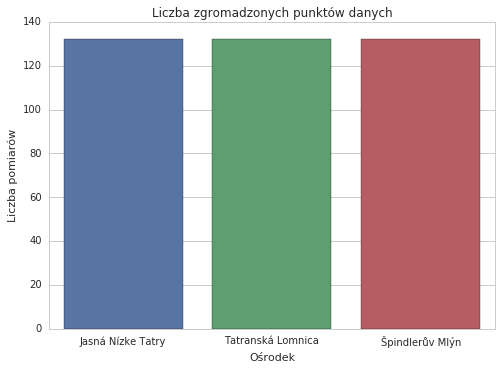

In [4]:
# Wizualizacja
sns.countplot(x='resort', data=df)

plt.title('Liczba zgromadzonych punktów danych')
plt.xlabel('Ośrodek')
plt.ylabel('Liczba pomiarów')

plt.show()

In [5]:
df['season'].value_counts()

High Season      294
Spring Schuss     93
First Snow         9
Name: season, dtype: int64

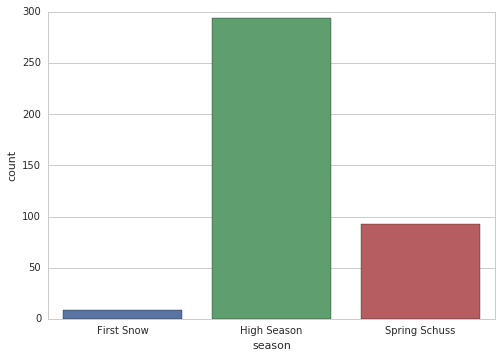

In [6]:
# Ile danych w sezonie
sns.countplot(x='season', data=df)
plt.show()

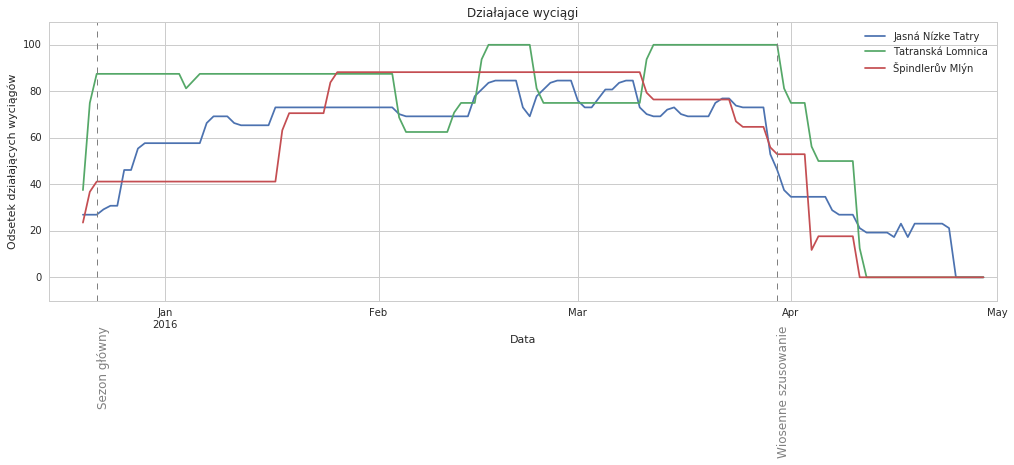

In [7]:
# Działające wyciągi
fig, ax = plt.subplots(figsize=(17, 5))

df.groupby(["resort", "day"])['active_lifts_avg'].mean().unstack('resort').plot(ax=ax)

ax.set_xlim(datetime.date(2015, 12, 15), datetime.date(2016, 5, 1))
ax.set_ylim([-10, 110])

ax.axvline(datetime.date(2015, 12, 22), color='grey', linestyle='--', lw=1)
ax.text(datetime.date(2015, 12, 22) , -25 , 'Sezon główny', color='grey', rotation=90)

ax.axvline(datetime.date(2016, 3, 30), color='grey', linestyle='--', lw=1)
ax.text(datetime.date(2016, 3, 30) , -25 , 'Wiosenne szusowanie', color='grey', rotation=90)

ax.set_xlabel("Data")
ax.set_ylabel("Odsetek działających wyciągów")
ax.set_title("Działajace wyciągi")

plt.legend(loc='best')

plt.show()

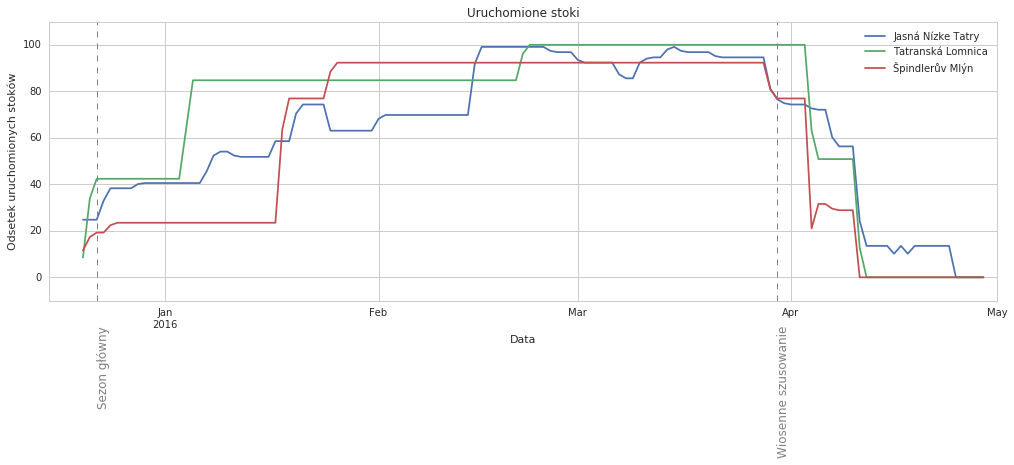

In [8]:
# Działające stoki
fig, ax = plt.subplots(figsize=(17, 5))

df.groupby(["resort", "day"])['active_slopes_avg'].mean().unstack('resort').plot(ax=ax)

ax.set_xlim(datetime.date(2015, 12, 15), datetime.date(2016, 5, 1))
ax.set_ylim([-10, 110])

ax.axvline(datetime.date(2015, 12, 22), color='grey', linestyle='--', lw=1)
ax.text(datetime.date(2015, 12, 22) , -25 , 'Sezon główny', color='grey', rotation=90)

ax.axvline(datetime.date(2016, 3, 30), color='grey', linestyle='--', lw=1)
ax.text(datetime.date(2016, 3, 30) , -25 , 'Wiosenne szusowanie', color='grey', rotation=90)

ax.set_xlabel("Data")
ax.set_ylabel("Odsetek uruchomionych stoków")
ax.set_title("Uruchomione stoki")

plt.legend(loc='best')

plt.show()

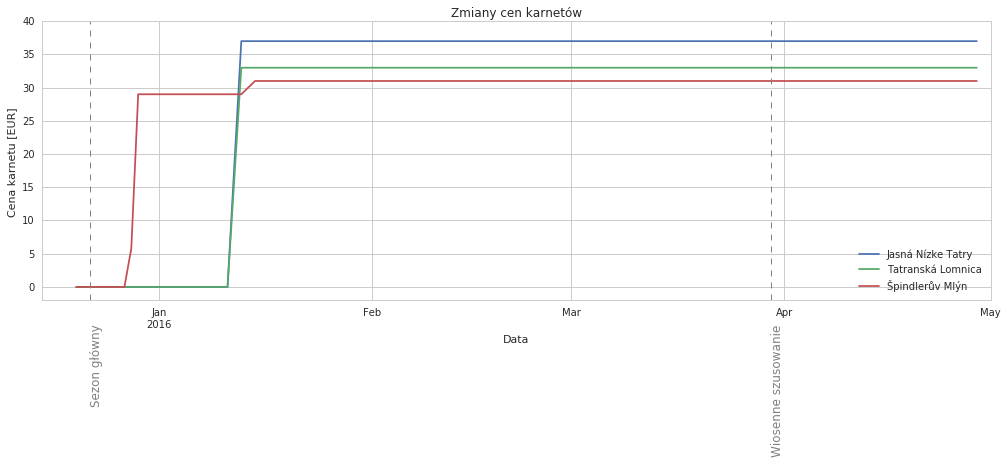

In [9]:
# Cena karnetu
fig, ax = plt.subplots(figsize=(17, 5))

df.groupby(["resort", "day"])['skipass_price_avg'].first().unstack('resort').plot(ax=ax)

ax.set_xlim(datetime.date(2015, 12, 15), datetime.date(2016, 5, 1))
ax.set_ylim([-2, 40])

ax.axvline(datetime.date(2015, 12, 22), color='grey', linestyle='--', lw=1)
ax.text(datetime.date(2015, 12, 22) , -7, 'Sezon główny', color='grey', rotation=90)

ax.axvline(datetime.date(2016, 3, 30), color='grey', linestyle='--', lw=1)
ax.text(datetime.date(2016, 3, 30) , -7, 'Wiosenne szusowanie', color='grey', rotation=90)

ax.set_xlabel("Data")
ax.set_ylabel("Cena karnetu [EUR]")
ax.set_title("Zmiany cen karnetów")

plt.legend(loc='best')

plt.show()

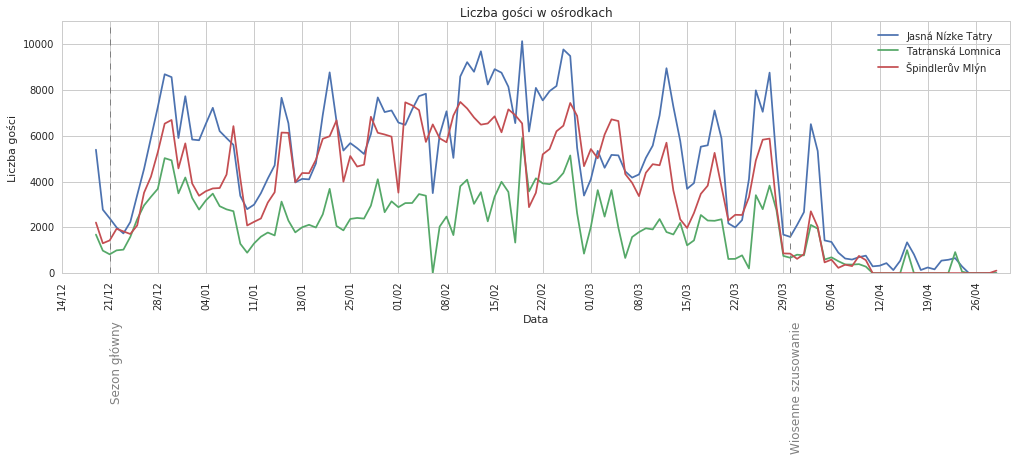

In [10]:
# Liczba gości
fig, ax = plt.subplots(figsize=(17, 5))

df.groupby(["resort", "day"])['guests'].first().unstack('resort').plot(ax=ax)

ax.set_xlim(datetime.date(2015, 12, 15), datetime.date(2016, 5, 1))
ax.set_ylim([-2, 11000])

ax.axvline(datetime.date(2015, 12, 22), color='grey', linestyle='--', lw=1)
ax.text(datetime.date(2015, 12, 22) , -2500 , 'Sezon główny', color='grey', rotation=90)

ax.axvline(datetime.date(2016, 3, 30), color='grey', linestyle='--', lw=1)
ax.text(datetime.date(2016, 3, 30) , -2500, 'Wiosenne szusowanie', color='grey', rotation=90)

ax.set_xlabel("Data")
ax.set_ylabel("Liczba gości")
ax.set_title("Liczba gości w ośrodkach")

ax.xaxis.set_major_locator(WeekdayLocator(byweekday=4))
ax.xaxis.set_major_formatter(DateFormatter('%d/%m'))

fig.autofmt_xdate(rotation=90, ha='center')

plt.legend(loc='best')

plt.show()

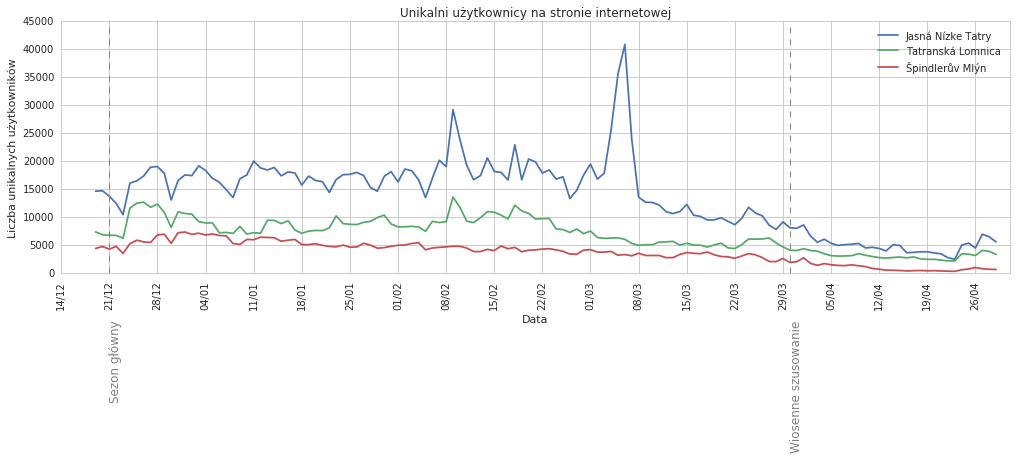

In [11]:
# UU z GA
fig, ax = plt.subplots(figsize=(17, 5))

df.groupby(["resort", "day"])['unique_users_all'].first().unstack('resort').plot(ax=ax)

ax.set_xlim(datetime.date(2015, 12, 15), datetime.date(2016, 5, 1))
ax.set_ylim([0, 45000])

ax.axvline(datetime.date(2015, 12, 22), color='grey', linestyle='--', lw=1)
ax.text(datetime.date(2015, 12, 22) , -10000 , 'Sezon główny', color='grey', rotation=90)

ax.axvline(datetime.date(2016, 3, 30), color='grey', linestyle='--', lw=1)
ax.text(datetime.date(2016, 3, 30) , -10000, 'Wiosenne szusowanie', color='grey', rotation=90)

ax.set_xlabel("Data")
ax.set_ylabel("Liczba unikalnych użytkowników")
ax.set_title("Unikalni użytkownicy na stronie internetowej")

ax.xaxis.set_major_locator(WeekdayLocator(byweekday=4))
ax.xaxis.set_major_formatter(DateFormatter('%d/%m'))

fig.autofmt_xdate(rotation=90, ha='center')

plt.legend(loc='best')

plt.show()

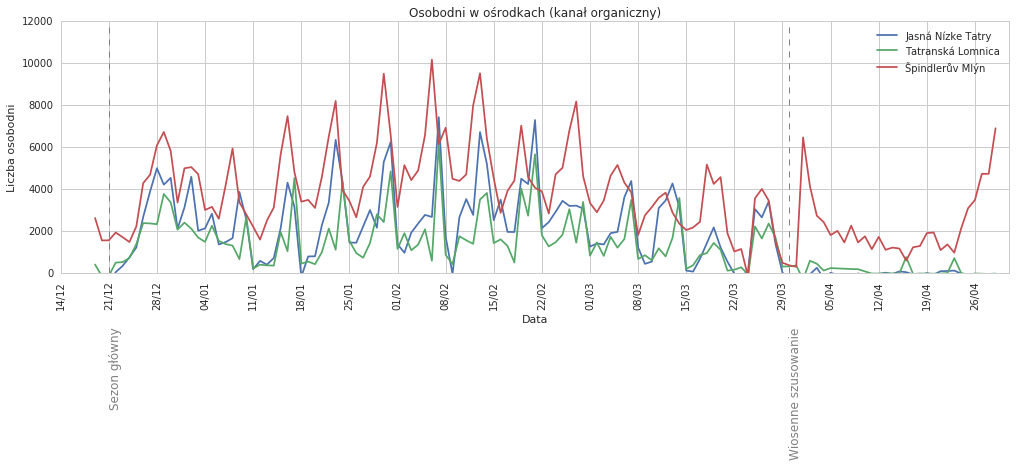

In [12]:
# MD organic
fig, ax = plt.subplots(figsize=(17, 5))

df.groupby(["resort", "day"])['man_days_organic'].first().unstack('resort').plot(ax=ax)

ax.set_xlim(datetime.date(2015, 12, 15), datetime.date(2016, 5, 1))
ax.set_ylim([0, 12000])

ax.axvline(datetime.date(2015, 12, 22), color='grey', linestyle='--', lw=1)
ax.text(datetime.date(2015, 12, 22) , -3000 , 'Sezon główny', color='grey', rotation=90)

ax.axvline(datetime.date(2016, 3, 30), color='grey', linestyle='--', lw=1)
ax.text(datetime.date(2016, 3, 30) , -3000, 'Wiosenne szusowanie', color='grey', rotation=90)

ax.set_xlabel("Data")
ax.set_ylabel("Liczba osobodni")
ax.set_title("Osobodni w ośrodkach (kanał organiczny)")

ax.xaxis.set_major_locator(WeekdayLocator(byweekday=4))
ax.xaxis.set_major_formatter(DateFormatter('%d/%m'))

fig.autofmt_xdate(rotation=90, ha='center')

plt.legend(loc='best')

plt.show()

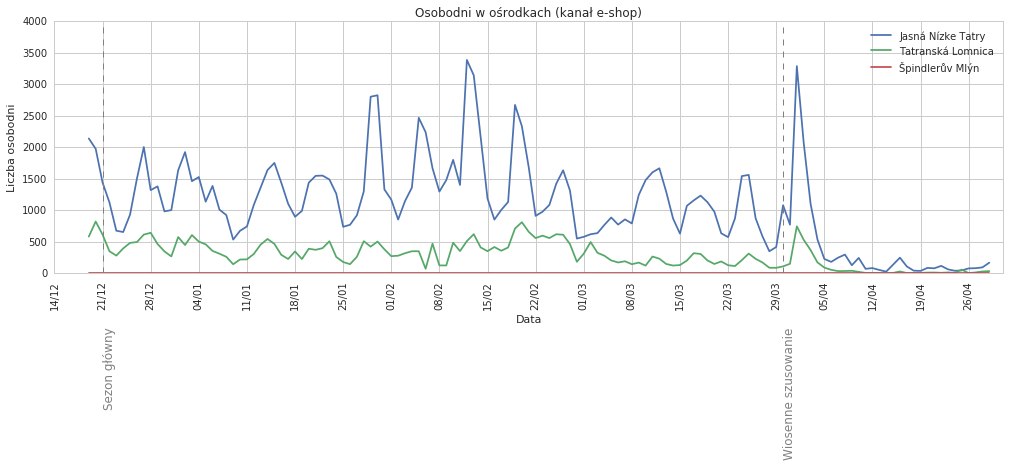

In [13]:
# MD eshop
fig, ax = plt.subplots(figsize=(17, 5))

df.groupby(["resort", "day"])['man_days_eshop'].first().unstack('resort').plot(ax=ax)

ax.set_xlim(datetime.date(2015, 12, 15), datetime.date(2016, 5, 1))
ax.set_ylim([0, 4000])

ax.axvline(datetime.date(2015, 12, 22), color='grey', linestyle='--', lw=1)
ax.text(datetime.date(2015, 12, 22) , -1000 , 'Sezon główny', color='grey', rotation=90)

ax.axvline(datetime.date(2016, 3, 30), color='grey', linestyle='--', lw=1)
ax.text(datetime.date(2016, 3, 30) , -1000, 'Wiosenne szusowanie', color='grey', rotation=90)

ax.set_xlabel("Data")
ax.set_ylabel("Liczba osobodni")
ax.set_title("Osobodni w ośrodkach (kanał e-shop)")

ax.xaxis.set_major_locator(WeekdayLocator(byweekday=4))
ax.xaxis.set_major_formatter(DateFormatter('%d/%m'))

fig.autofmt_xdate(rotation=90, ha='center')

plt.legend(loc='best')

plt.show()

## Hipotezy
Ponieważ statystyczny rozkład zmianych w większości przypadków odbiega od rozkładu naturalnego. Hipotezy weryfikowane będą wizualnie.

> Korelacja między zmiennymi nie oznacza przyczynowości

Należy zwrócić uwagę na różnice w skalach na poszczególnych wykresach - są one przeskalowane w zależności od ośrodka.

### 1. Ilość uruchomionych wyciągów wpływa na sprzedaż. Im jest ich więcej, tym jest większa.
Wykres przedstawiający zależność całkowitego przychodu netto (suma ruchu organicznego i e-shop) w zależności od odsetku aktywnych wyciągów. Dodatkowo innym kolorem zaznaczono punkty danych z każdego sezonu.

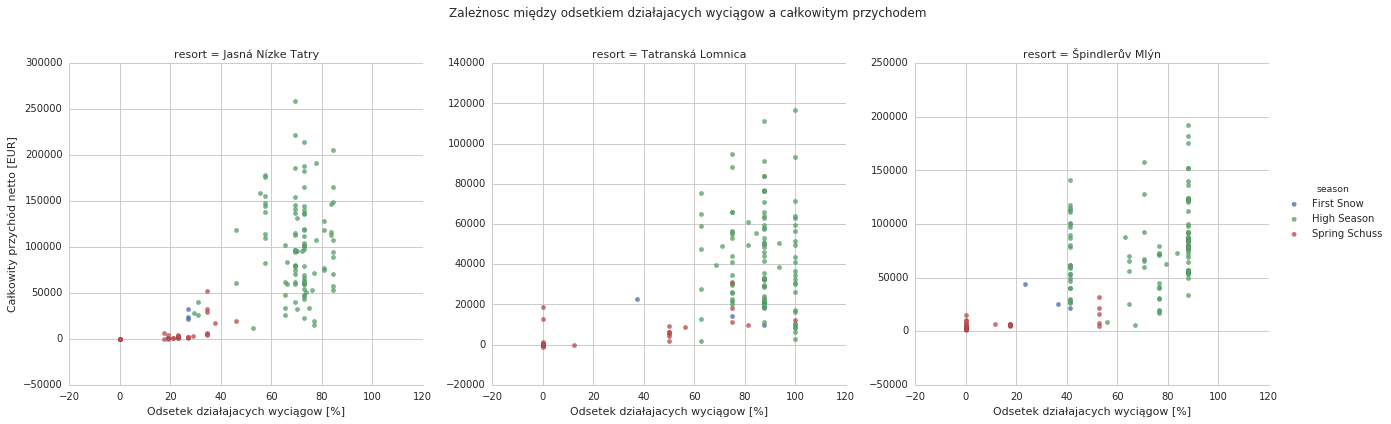

In [14]:
kws = dict(s=20, linewidth=.1, edgecolor="black", alpha=0.8)

g = sns.FacetGrid(df, col='resort', hue='season', size=6, sharey=False)
g = (g.map(plt.scatter, "active_lifts_avg", "net_income_all", **kws)).add_legend()

plt.subplots_adjust(top=0.85)
g.fig.suptitle('Zależnosc między odsetkiem działajacych wyciągow a całkowitym przychodem')
g.set_axis_labels(x_var='Odsetek działajacych wyciągow [%]', y_var='Całkowity przychód netto [EUR]')
g.savefig('/images/h1.png', dpi=300)
plt.show()

Istnieje zależność - **wraz ze wzrostem ilości działających wyciągów rośnie przychód**. W przypadku ośrodka Jasna największy przychód osiągnięto przy ok 70% pracujących wyciągów. Dla Szpinderowego Młyna duże przychody były generowane także dal 40% działających wyciągów.

### 2. Informacje o opadach śniegu wpływają na wzmiankowanie w sieci (Brand 24 all mentions), a to przekłada się na sprzedaż, np. im większe opady, tym więcej wzmianek, a to z kolei wpływa na większą sprzedaż.

Powyższa hipoteza została rozbita na dwie części:

1. Czy fakt opadów śniegu wpływaja na ilość wzmianek w sieci,
2. Czy ilość wzmianek wpływa na sprzedaż

#### Czy fakt opadów śniegu wpływaja na ilość wzmianek w sieci
Poniższy wykres przedstawia zależność wszystkich zgromadzonych wzmianek w sieci dla ośrodka Jasná Nízke Tatry w zależności od faktu czy danego dnia zarejestrowano śnieg (w pozostałych ośrodkach opady nie zostały znalezione - prawdopodobnie przyczyna serwisu pogodowego).

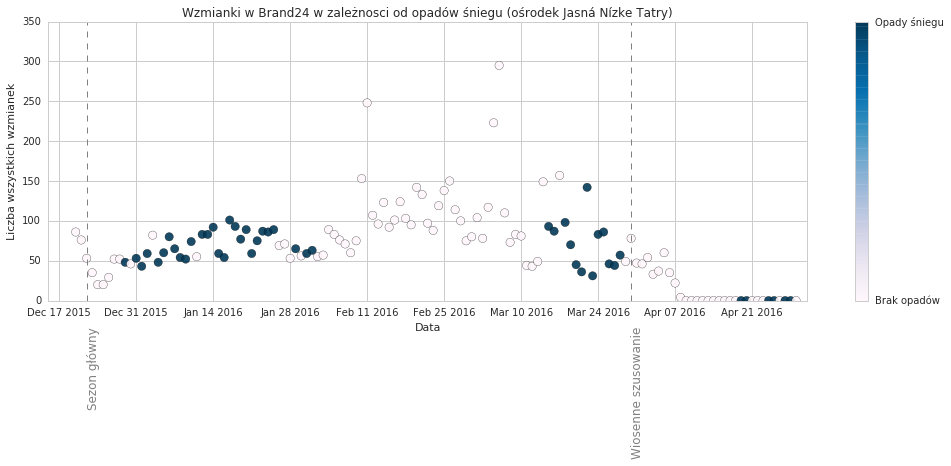

In [15]:
fig, ax = plt.subplots(figsize=(17, 5))

bs = jasna.groupby('day')['brand24_all_mentions', 'was_snowing'].mean()
cm = plt.cm.get_cmap('PuBu')

sc = plt.scatter(
    bs.index,
    bs['brand24_all_mentions'],
    c = bs['was_snowing'],
    cmap = cm,
    s = 70,
    alpha=.9
)

ax.set_xlim(datetime.date(2015, 12, 15), datetime.date(2016, 5, 1))
ax.set_ylim([0, 350])

ax.axvline(datetime.date(2015, 12, 22), color='grey', linestyle='--', lw=1)
ax.text(datetime.date(2015, 12, 22) , -45 , 'Sezon główny', color='grey', rotation=90)

ax.axvline(datetime.date(2016, 3, 30), color='grey', linestyle='--', lw=1)
ax.text(datetime.date(2016, 3, 30) , -45, 'Wiosenne szusowanie', color='grey', rotation=90)

ax.set_xlabel("Data")
ax.set_ylabel("Liczba wszystkich wzmianek")
ax.set_title("Wzmianki w Brand24 w zależnosci od opadów śniegu (ośrodek Jasná Nízke Tatry)")

cbar = plt.colorbar(sc, ticks=[0,1])
cbar.ax.set_yticklabels(['Brak opadów', 'Opady śniegu'])

plt.show()

Zastanawiające w powyższym wykresie jest fakt, że od początku lutego do połowy marca nie zarejestrowano żadnych opadów śniegu.

Zarejestrowano delikatną pozytywną korelację w styczniu - jednak opady śniegu wcale nie muszą być przyczyną - np. pod koniec marca korelacja jest odwrotna - pomimo opadów śniegu liczba wzmianek maleje. Brak wyraźnego związku przyczynowo-skutkowego.

#### Czy ilość wzmianek wpływa na sprzedaż
Podobnie jak wyżej analizę przeprowadzono dla ośrodka Jasná. Porównano zależność między iloścą wszystkich wzmianek do całkowitego przychodu netto.

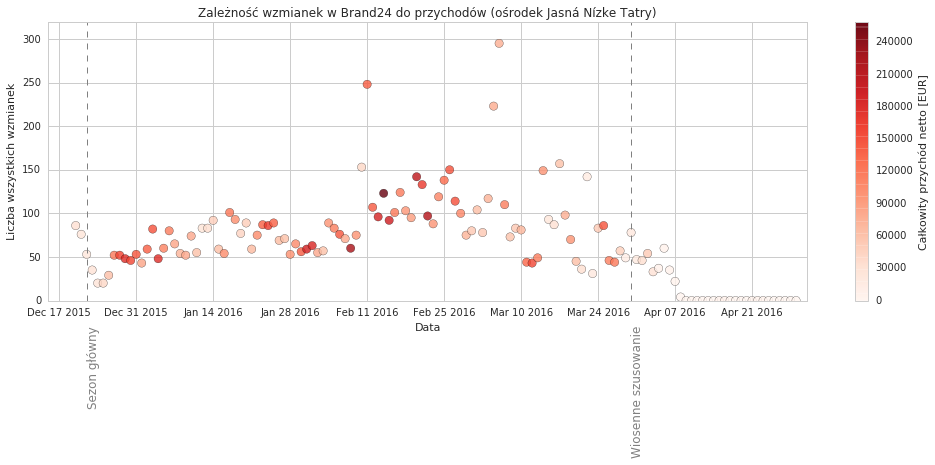

In [16]:
fig, ax = plt.subplots(figsize=(17, 5))

b24all_jasna_df = jasna.groupby('day')['brand24_all_mentions', 'net_income_all'].mean()
cm = plt.cm.get_cmap('Reds')

sc = plt.scatter(
    b24all_jasna_df.index,
    b24all_jasna_df['brand24_all_mentions'],
    c = b24all_jasna_df['net_income_all'],
    cmap = cm,
    s = 70,
    alpha=.8
)

ax.set_xlim(datetime.date(2015, 12, 15), datetime.date(2016, 5, 1))
ax.set_ylim([0, 320])

ax.axvline(datetime.date(2015, 12, 22), color='grey', linestyle='--', lw=1)
ax.text(datetime.date(2015, 12, 22) , -40 , 'Sezon główny', color='grey', rotation=90)

ax.axvline(datetime.date(2016, 3, 30), color='grey', linestyle='--', lw=1)
ax.text(datetime.date(2016, 3, 30) , -40, 'Wiosenne szusowanie', color='grey', rotation=90)

ax.set_xlabel("Data")
ax.set_ylabel("Liczba wszystkich wzmianek")
ax.set_title("Zależność wzmianek w Brand24 do przychodów (ośrodek Jasná Nízke Tatry)")

cbar = plt.colorbar(sc)
cbar.set_label('Całkowity przychód netto [EUR]')

plt.show()

Od ok 11 lutego wiadać większą ilość wykrytych wzmianek. Punkty mają wtedy mocno czerwony odcień co świadczy o wysokich przychodach. 

Patrząc na poprzedni wykres w podanym przedziale czasowym nie występowały opady śniegu. Nie widać wyraźnej korelacji między ciągiem zależności opady śniegu -> wzmianki -> sprzedaż.

### 3. Aktywne trasy i niska temperatura wpływają na wzrost sprzedaży. 

Podobnie jak wyżej hipoteza zostaje rozbita na dwie:
1. Zależność odsetku aktywnych tras do całkowitego przychodu netto,
2. Zależność maksymalnej zarejestrowanej temperatury do całkowitego przychodu netto (ew. średniej temp w nocy)

Oba przypadki zostały rozpatrzone osobno dla 3 ośrodków uwzględniając sezon.

#### Zależność odsetku aktywnych tras do całkowitego przychodu netto

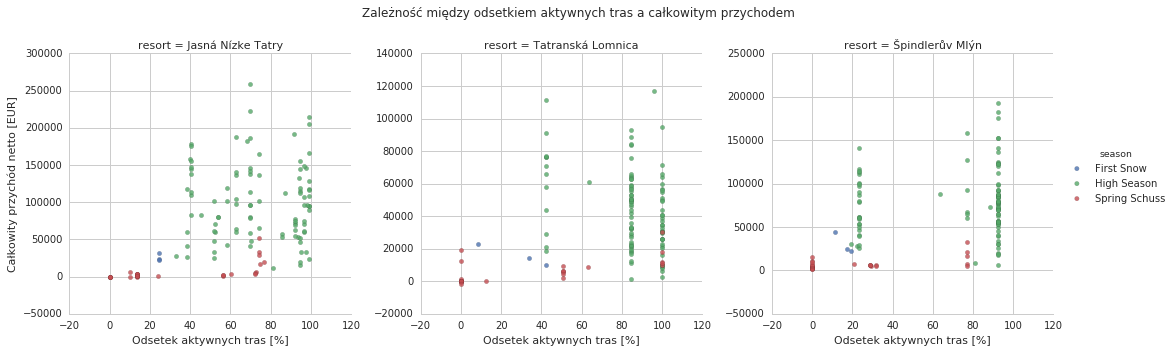

In [17]:
kws = dict(s=20, linewidth=.1, edgecolor="black", alpha=0.8)

g = sns.FacetGrid(df, col='resort', hue='season', size=5, sharey=False)
g = (g.map(plt.scatter, "active_slopes_avg", "net_income_all", **kws)).add_legend()

plt.subplots_adjust(top=0.85)
g.fig.suptitle('Zależność między odsetkiem aktywnych tras a całkowitym przychodem')
g.set_axis_labels(x_var='Odsetek aktywnych tras [%]', y_var='Całkowity przychód netto [EUR]')
plt.show()

Podobnie jak w przypadku pierwszej hipotezy - większa ilość aktywnych tras oznacza większe przychody. Nie jest to jednak wyraźna reguła

**Ciekawe**:
- ośrodek Jasna generuje podobne przychody mają uruchomione 40-60% tras,
- ośrodek Tatranska w wysokim sezonie miał otwarte jedynie 40% tras i również generował podobną ilość przychodów gdy uruchiomione było 80-100%,
- przez pewien okres czasu w Szpindlerowym Młynie czynne było tylko 20% tras co także generowało przychody

#### Zależność maksymalnej zarejestrowanej temperatury do całkowitego przychodu netto
Poniżej przedstawiono zależność pomiędzy maksymalną temperaturą zmierzoną danego dnia w ośrodu i przychodem.

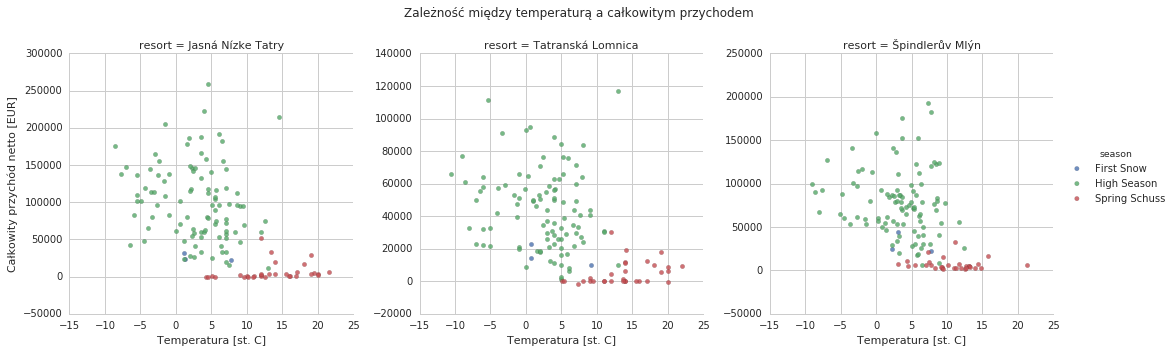

In [18]:
kws = dict(s=20, linewidth=.1, edgecolor="black", alpha=0.8)

g = sns.FacetGrid(df, col='resort', hue='season', size=5, sharey=False)
g = (g.map(plt.scatter, "temperature_max", "net_income_all", **kws)).add_legend()

plt.subplots_adjust(top=0.85)
g.fig.suptitle('Zależność między temperaturą a całkowitym przychodem')
g.set_axis_labels(x_var='Temperatura [st. C]', y_var='Całkowity przychód netto [EUR]')
plt.show()

Analizując oba wykresy temperatura nie wydaje się mieć wpływu na przychody. Występuje negatywna korelacja, jednak rozbieżności są zbyt duże aby mówić o przyczynowości

**Spostrzeżenia**:
- brak wyraźnego związku między zarejestrowaną temperaturą a przychodem,
- *wiosenne szusowanie* zdecydowanie wyróżnia się w każdym przypadku - wyższa temperatura, niższy przychód,
- w Tatrzanskiej najwiekszy przychod zarejstrowany dla $T_{max}$ ok 12 st. C

### 4. Niska temperatura, opady śniegu wpływają na wzrost sprzedaży w dwóch - trzech kolejnych dniach.
Zwizualizowany został wpływ temperatury w zależności od przychodu dla 3 ośrodków. Opady śniegu **nie zostały uwzględnione** z powodów braku danych dla 2 stoków (ich zależność jest pośrednio przedstawiona w hipotezie 2).

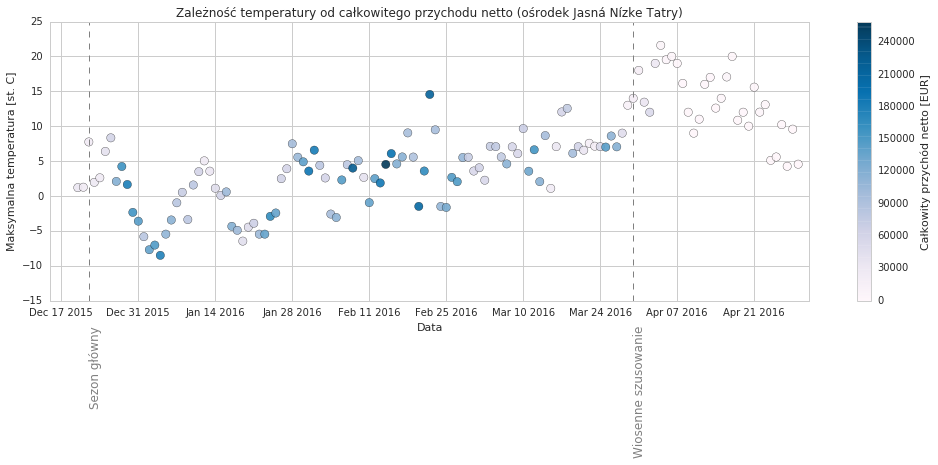

In [19]:
fig, ax = plt.subplots(figsize=(17, 5))

bs = jasna.groupby('day')['temperature_max', 'net_income_all'].mean()
cm = plt.cm.get_cmap('PuBu')

sc = plt.scatter(
    bs.index,
    bs['temperature_max'],
    c = bs['net_income_all'],
    cmap = cm,
    s = 70,
    alpha=.9
)

ax.set_xlim(datetime.date(2015, 12, 15), datetime.date(2016, 5, 1))
ax.set_ylim([-15, 25])

ax.axvline(datetime.date(2015, 12, 22), color='grey', linestyle='--', lw=1)
ax.text(datetime.date(2015, 12, 22) , -20 , 'Sezon główny', color='grey', rotation=90)

ax.axvline(datetime.date(2016, 3, 30), color='grey', linestyle='--', lw=1)
ax.text(datetime.date(2016, 3, 30) , -20, 'Wiosenne szusowanie', color='grey', rotation=90)

ax.set_xlabel("Data")
ax.set_ylabel("Maksymalna temperatura [st. C]")
ax.set_title("Zależność temperatury od całkowitego przychodu netto (ośrodek Jasná Nízke Tatry)")

cbar = plt.colorbar(sc)
cbar.set_label('Całkowity przychód netto [EUR]')

plt.show()

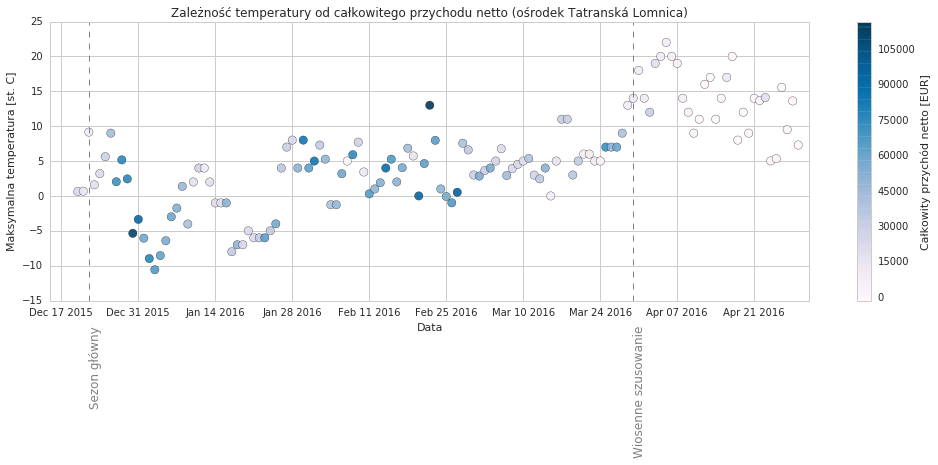

In [20]:
fig, ax = plt.subplots(figsize=(17, 5))

bs = tatranska.groupby('day')['temperature_max', 'net_income_all'].mean()
cm = plt.cm.get_cmap('PuBu')

sc = plt.scatter(
    bs.index,
    bs['temperature_max'],
    c = bs['net_income_all'],
    cmap = cm,
    s = 70,
    alpha=.9
)

ax.set_xlim(datetime.date(2015, 12, 15), datetime.date(2016, 5, 1))
ax.set_ylim([-15, 25])

ax.axvline(datetime.date(2015, 12, 22), color='grey', linestyle='--', lw=1)
ax.text(datetime.date(2015, 12, 22) , -20 , 'Sezon główny', color='grey', rotation=90)

ax.axvline(datetime.date(2016, 3, 30), color='grey', linestyle='--', lw=1)
ax.text(datetime.date(2016, 3, 30) , -20, 'Wiosenne szusowanie', color='grey', rotation=90)

ax.set_xlabel("Data")
ax.set_ylabel("Maksymalna temperatura [st. C]")
ax.set_title("Zależność temperatury od całkowitego przychodu netto (ośrodek Tatranská Lomnica)")

cbar = plt.colorbar(sc)
cbar.set_label('Całkowity przychód netto [EUR]')

plt.savefig('/images/h4_tatranska_lomnica.png', dpi=300)
plt.show()

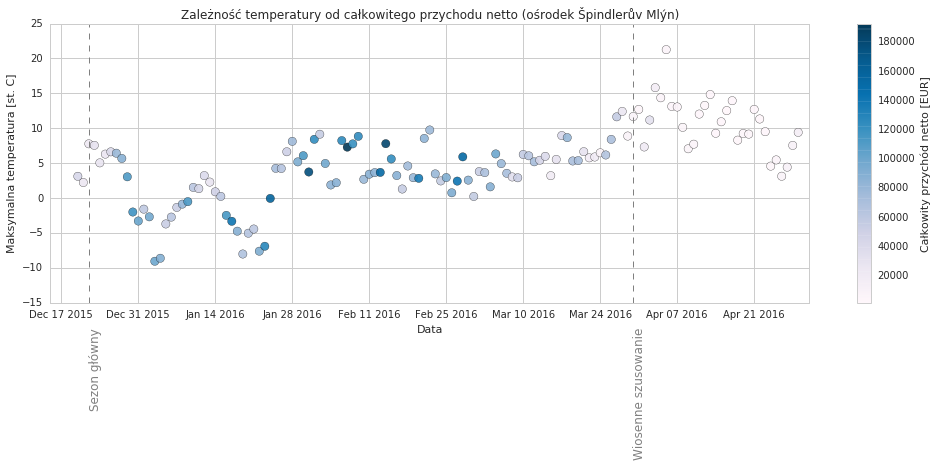

In [21]:
fig, ax = plt.subplots(figsize=(17, 5))

bs = spindleruv.groupby('day')['temperature_max', 'net_income_all'].mean()
cm = plt.cm.get_cmap('PuBu')

sc = plt.scatter(
    bs.index,
    bs['temperature_max'],
    c = bs['net_income_all'],
    cmap = cm,
    s = 70,
    alpha=.9
)

ax.set_xlim(datetime.date(2015, 12, 15), datetime.date(2016, 5, 1))
ax.set_ylim([-15, 25])

ax.axvline(datetime.date(2015, 12, 22), color='grey', linestyle='--', lw=1)
ax.text(datetime.date(2015, 12, 22) , -20 , 'Sezon główny', color='grey', rotation=90)

ax.axvline(datetime.date(2016, 3, 30), color='grey', linestyle='--', lw=1)
ax.text(datetime.date(2016, 3, 30) , -20, 'Wiosenne szusowanie', color='grey', rotation=90)

ax.set_xlabel("Data")
ax.set_ylabel("Maksymalna temperatura [st. C]")
ax.set_title("Zależność temperatury od całkowitego przychodu netto (ośrodek Špindlerův Mlýn)")

cbar = plt.colorbar(sc)
cbar.set_label('Całkowity przychód netto [EUR]')

plt.show()

Na początku sezonu głównego, wraz ze spadkiem temperatury rośnie przychód, po chwili następuje odbicie - temperatura rośnie - przychody maleją. Tu także nie widać związku przczynowo-skutkowego.

### 5. Wysokość kursu EUR/PLN negatywnie odbija się na sprzedaży. Im wyższy kurs, tym mniejsza sprzedaż.
Dla 3 ośrodków porównano osiągnięty przychód z kursem EUR/PLN panującym danego dnia (z uwzględnieniem sezonu).

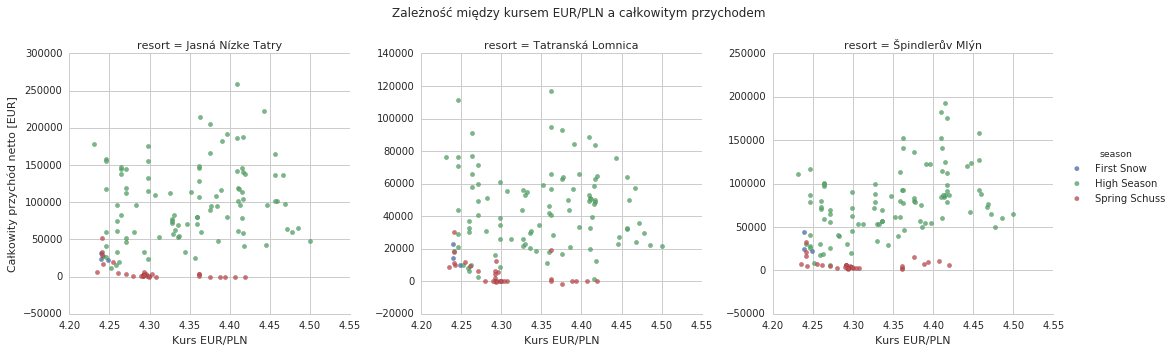

In [22]:
kws = dict(s=20, linewidth=.1, edgecolor="black", alpha=0.8)

g = sns.FacetGrid(df, col='resort', hue='season', size=5, sharey=False)
g = (g.map(plt.scatter, "EURPLN", "net_income_all", **kws)).add_legend()

plt.subplots_adjust(top=0.85)
g.fig.suptitle('Zależność między kursem EUR/PLN a całkowitym przychodem')
g.set_axis_labels(x_var='Kurs EUR/PLN', y_var='Całkowity przychód netto [EUR]')
plt.show()

Brak wyraźnego powiązania

### 6. Wysokość ceny paliwa wpływa na sprzedaż. Im droższe paliwo, tym niższa sprzedaż skipassów. 
Dla 3 ośrodków porównano osiągnięty przychód z aktualną ceną paliwa PB95 danego dnia (z uwzględnieniem sezonu).

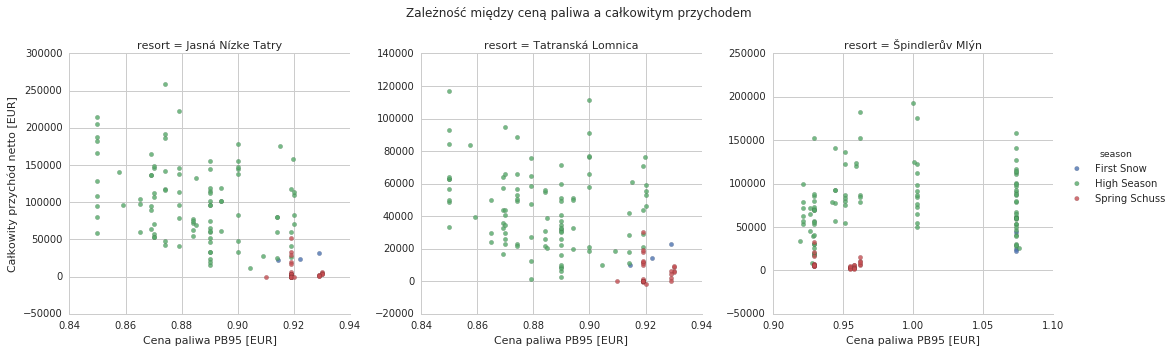

In [23]:
kws = dict(s=20, linewidth=.1, edgecolor="black", alpha=0.8)

g = sns.FacetGrid(df, col='resort', hue='season', size=5, sharey=False, sharex=False)
g = (g.map(plt.scatter, "fuel_eur_price", "net_income_all", **kws)).add_legend()

plt.subplots_adjust(top=0.85)
g.fig.suptitle('Zależność między ceną paliwa a całkowitym przychodem')
g.set_axis_labels(x_var='Cena paliwa PB95 [EUR]', y_var='Całkowity przychód netto [EUR]')
plt.show()

Brak powiązania. W okresie wiosennym cena paliwa była najwyższa.

### 7. Im wyższy wskaźnik pozytywnych wzmianek wg Brand 24, tym w kolejnych 5 dniach wyższa sprzedaż.
http://matplotlib.org/1.2.1/examples/pylab_examples/show_colormaps.html

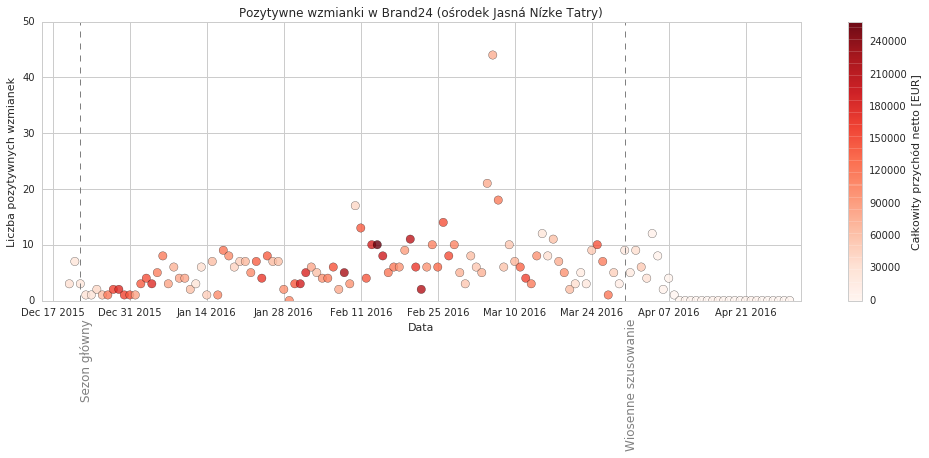

In [24]:
fig, ax = plt.subplots(figsize=(17, 5))

b24_jasna_df = jasna.groupby('day')['brand24_positive_mentions', 'net_income_all'].mean()
cm = plt.cm.get_cmap('Reds')

sc = plt.scatter(
    b24_jasna_df.index,
    b24_jasna_df['brand24_positive_mentions'],
    c = b24_jasna_df['net_income_all'],
    cmap = cm,
    s = 70,
    alpha=.8
)

ax.set_xlim(datetime.date(2015, 12, 15), datetime.date(2016, 5, 1))
ax.set_ylim([0, 50])

ax.axvline(datetime.date(2015, 12, 22), color='grey', linestyle='--', lw=1)
ax.text(datetime.date(2015, 12, 22) , -5 , 'Sezon główny', color='grey', rotation=90)

ax.axvline(datetime.date(2016, 3, 30), color='grey', linestyle='--', lw=1)
ax.text(datetime.date(2016, 3, 30) , -5, 'Wiosenne szusowanie', color='grey', rotation=90)

ax.set_xlabel("Data")
ax.set_ylabel("Liczba pozytywnych wzmianek")
ax.set_title("Pozytywne wzmianki w Brand24 (ośrodek Jasná Nízke Tatry)")

cbar = plt.colorbar(sc)
cbar.set_label('Całkowity przychód netto [EUR]')

plt.show()

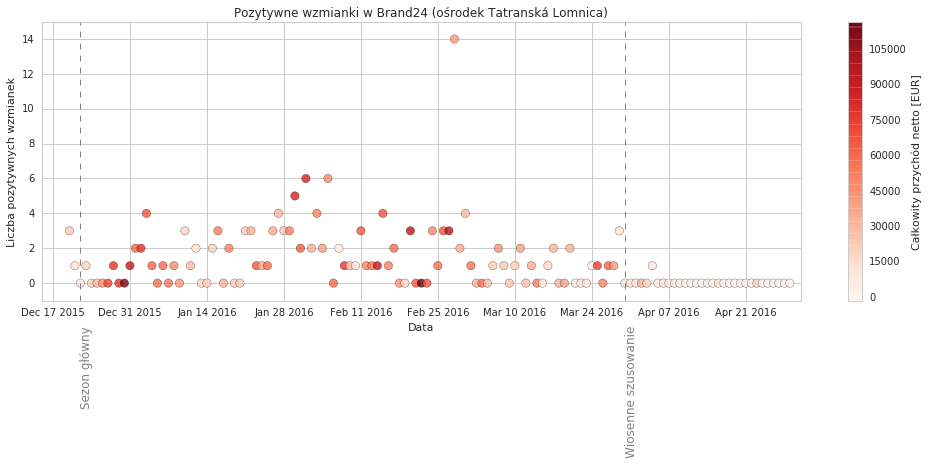

In [25]:
fig, ax = plt.subplots(figsize=(17, 5))

b24_tatranska_df = tatranska.groupby('day')['brand24_positive_mentions', 'net_income_all'].mean()
cm = plt.cm.get_cmap('Reds')

sc = plt.scatter(
    b24_tatranska_df.index,
    b24_tatranska_df['brand24_positive_mentions'],
    c = b24_tatranska_df['net_income_all'],
    cmap = cm,
    s = 70,
    alpha=.8
)

ax.set_xlim(datetime.date(2015, 12, 15), datetime.date(2016, 5, 1))
ax.set_ylim([-1, 15])

ax.axvline(datetime.date(2015, 12, 22), color='grey', linestyle='--', lw=1)
ax.text(datetime.date(2015, 12, 22) , -3 , 'Sezon główny', color='grey', rotation=90)

ax.axvline(datetime.date(2016, 3, 30), color='grey', linestyle='--', lw=1)
ax.text(datetime.date(2016, 3, 30) , -3, 'Wiosenne szusowanie', color='grey', rotation=90)

ax.set_xlabel("Data")
ax.set_ylabel("Liczba pozytywnych wzmianek")
ax.set_title("Pozytywne wzmianki w Brand24 (ośrodek Tatranská Lomnica)")

cbar = plt.colorbar(sc)
cbar.set_label('Całkowity przychód netto [EUR]')

plt.show()

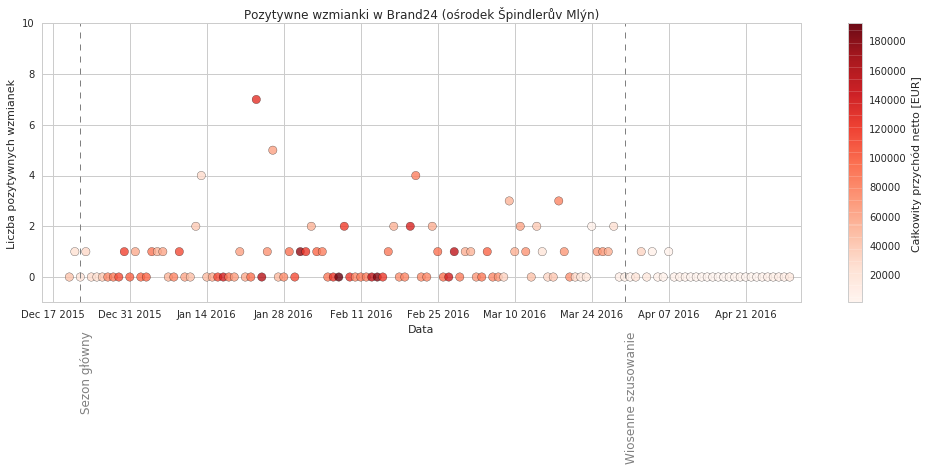

In [26]:
fig, ax = plt.subplots(figsize=(17, 5))

b24_spindleruv_df = spindleruv.groupby('day')['brand24_positive_mentions', 'net_income_all'].mean()
cm = plt.cm.get_cmap('Reds')

sc = plt.scatter(
    b24_spindleruv_df.index,
    b24_spindleruv_df['brand24_positive_mentions'],
    c = b24_spindleruv_df['net_income_all'],
    cmap = cm,
    s = 70,
    alpha=.8
)

ax.set_xlim(datetime.date(2015, 12, 15), datetime.date(2016, 5, 1))
ax.set_ylim([-1, 10])

ax.axvline(datetime.date(2015, 12, 22), color='grey', linestyle='--', lw=1)
ax.text(datetime.date(2015, 12, 22) , -2.5, 'Sezon główny', color='grey', rotation=90)

ax.axvline(datetime.date(2016, 3, 30), color='grey', linestyle='--', lw=1)
ax.text(datetime.date(2016, 3, 30) , -2.5, 'Wiosenne szusowanie', color='grey', rotation=90)

ax.set_xlabel("Data")
ax.set_ylabel("Liczba pozytywnych wzmianek")
ax.set_title("Pozytywne wzmianki w Brand24 (ośrodek Špindlerův Mlýn)")

cbar = plt.colorbar(sc)
cbar.set_label('Całkowity przychód netto [EUR]')

plt.show()

Zarejestrowano relatywnie małą ilość pozytywnych wzmianek. Analizują wykresy nie widać powiązania między ich ilością a przychodem sprzedażowym.

### 8. Na sprzedaż w wysokim sezonie większy wpływ mają wzmianki internautów (Brand24) niż temperatura i opady śniegu. 

W hipotezie 3 przedstawiono wpływ temperatrury na sprzedaż. Poniżej dodatkowo przedstawiona zależność od ilości wzmianek (w zalezności od ośrodka).

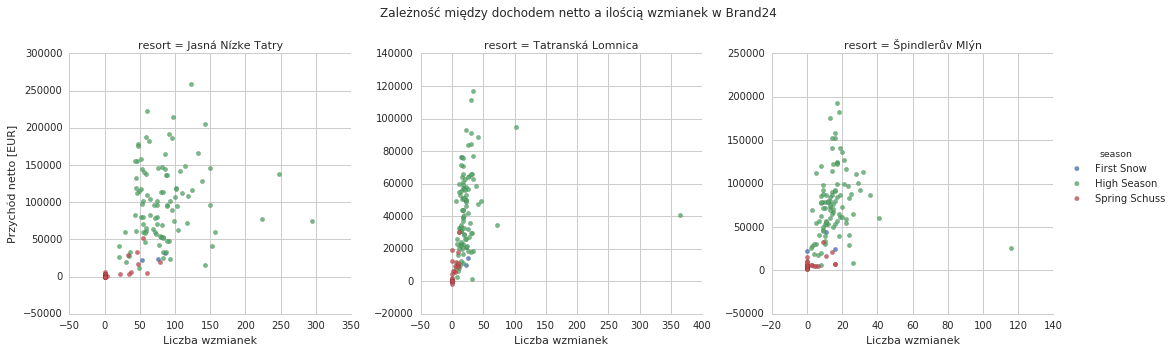

In [27]:
kws = dict(s=20, linewidth=.1, edgecolor="black", alpha=0.8)

g = sns.FacetGrid(df, col='resort', hue='season', size=5, sharey=False, sharex=False)
g = (g.map(plt.scatter, "brand24_all_mentions", "net_income_all", **kws)).add_legend()

plt.subplots_adjust(top=0.85)
g.fig.suptitle('Zależność między dochodem netto a ilością wzmianek w Brand24')
g.set_axis_labels(x_var='Liczba wzmianek', y_var='Przychód netto [EUR]')
plt.show()

Anomalie:

In [55]:
jasna[jasna['brand24_all_mentions'] > 200]

active_lifts_avg  active_slopes_avg  cloudiness_avg        day  \
159          69.23077           69.81982           85.00 2016-02-11   
228          80.76923           92.34234           67.60 2016-03-05   
231          80.76923           92.34234           41.75 2016-03-06   

     humidity_avg       lat       lon overall_conditions   rain  \
159         91.50  48.96849  19.58556             Clouds  0.000   
228         82.60  48.96849  19.58556               Rain  0.455   
231         87.75  48.96849  19.58556             Clouds  0.000   

                resort       season  skipass_price_avg  snow  temperature_max  \
159  Jasná Nízke Tatry  High Season               37.0   0.0            -0.96   
228  Jasná Nízke Tatry  High Season               37.0   0.0             7.07   
231  Jasná Nízke Tatry  High Season               37.0   0.0             5.59   

     temperature_night_avg  wind_speed_avg   country  fuel_eur_price holiday  \
159                 -2.080          2.6025  Slovakia           0.879   False   
228                  1.790          3.5640  Slovakia           0.884   False   
231                  0.315          1.9225  Slovakia           0.884   False   

     brand24_negative_mentions  brand24_netural_mentions  \
159                          3                       232   
228                         17                       185   
231                          4                       247   

     brand24_positive_mentions  guests  net_income_organic  \
159                         13    8586            91037.58   
228                         21    5142            55155.03   
231                         44    4443            54810.01   

     ski_passes_sold_organic  man_days_organic  net_income_eshop  \
159                     2772              2676           46346.0   
228                     2160              1981           22064.0   
231                     1143              3630           20377.0   

     ski_passes_sold_eshop  man_days_eshop  unique_users_poland  \
159                    768            1803                 6553   
228                    357             888                 3430   
231                    421             775                 4089   

     unique_users_all  EURPLN  net_income_all  brand24_all_mentions  \
159             23927  4.4198       137383.58                   248   
228             35620  4.3276        77219.03                   223   
231             40898  4.3276        75187.01                   295   

    was_snowing was_raining good_weather  
159       False       False        False  
228       False        True        False  
231       False       False        False

In [56]:
tatranska[tatranska['brand24_all_mentions'] > 100]

active_lifts_avg  active_slopes_avg  cloudiness_avg        day  \
208              75.0              100.0            15.0 2016-02-27   
211              75.0              100.0            69.5 2016-02-28   

     humidity_avg       lat       lon overall_conditions  rain  \
208         70.25  49.16618  20.28085              Clear   0.0   
211         79.50  49.16618  20.28085             Clouds   0.0   

                resort       season  skipass_price_avg  snow  temperature_max  \
208  Tatranská Lomnica  High Season               33.0   0.0             0.52   
211  Tatranská Lomnica  High Season               33.0   0.0             7.56   

     temperature_night_avg  wind_speed_avg   country  fuel_eur_price holiday  \
208                 -7.305          1.6750  Slovakia            0.87    True   
211                  1.545          2.3275  Slovakia            0.87    True   

     brand24_negative_mentions  brand24_netural_mentions  \
208                          0                       100   
211                          3                       347   

     brand24_positive_mentions  guests  net_income_organic  \
208                          3    5138            80872.84   
211                         14    2615            30299.00   

     ski_passes_sold_organic  man_days_organic  net_income_eshop  \
208                     1943              3058           13952.8   
211                      -29              1464           10670.0   

     ski_passes_sold_eshop  man_days_eshop  unique_users_poland  \
208                    350             614                 1814   
211                    200             466                 1716   

     unique_users_all  EURPLN  net_income_all  brand24_all_mentions  \
208              7323  4.3618        94825.64                   103   
211              7930  4.3618        40969.00                   364   

    was_snowing was_raining good_weather  
208       False       False         True  
211       False       False        False

In [57]:
spindleruv[spindleruv['brand24_all_mentions'] > 100]

active_lifts_avg  active_slopes_avg  cloudiness_avg        day  \
299          64.70588           92.30769            77.0 2016-03-28   

     humidity_avg        lat        lon overall_conditions    rain  \
299         87.75  50.718246  15.642619             Clouds  0.2475   

              resort       season  skipass_price_avg  snow  temperature_max  \
299  Špindlerův Mlýn  High Season               31.0   0.0             12.4   

     temperature_night_avg  wind_speed_avg         country  fuel_eur_price  \
299                  7.465          3.6675  Czech Republic           0.929   

    holiday  brand24_negative_mentions  brand24_netural_mentions  \
299    True                          0                       114   

     brand24_positive_mentions  guests  net_income_organic  \
299                          2    2912           20843.142   

     ski_passes_sold_organic  man_days_organic  net_income_eshop  \
299                      896              1513           4411.34   

     ski_passes_sold_eshop  man_days_eshop  unique_users_poland  \
299                    253               0                  225   

     unique_users_all  EURPLN  net_income_all  brand24_all_mentions  \
299              2103  4.2705       25254.482                   116   

    was_snowing was_raining good_weather  
299       False        True        False

Dla Jasnej brak powiązań - dla przykładowej liczby wzmianek wariancja w przychodzie jest zbyt duża (mimo wrażenia dodatniej korelacji).

Ciekawe zachowanie widać w przypadku Tatrzańskiej Łomnicy - w przedziale 25-50 wzmianek przychód zdaje się rosnąć liniowo. Poniższy wykres pokazuje zbliżenie dla danego obszaru

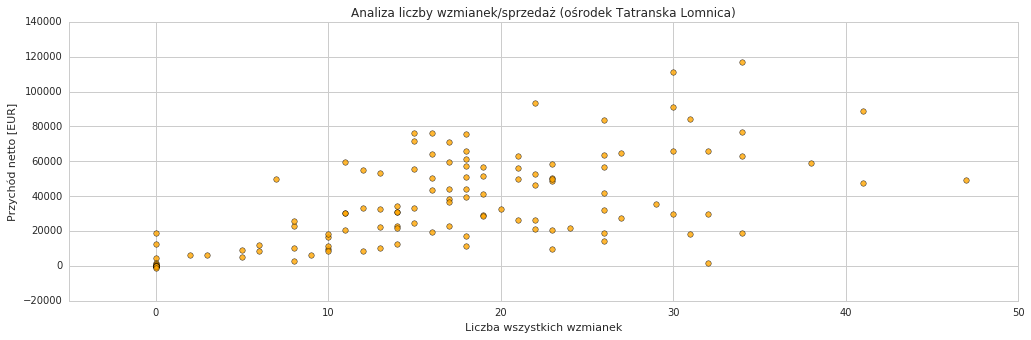

In [28]:
fig, ax = plt.subplots(figsize=(17, 5))

kws = dict(s=30, linewidth=.5, color="orange", edgecolor="black", alpha=0.8)

plt.scatter(tatranska['brand24_all_mentions'], tatranska['net_income_all'], **kws)

ax.set_xlim(-5, 50)
ax.set_xlabel("Liczba wszystkich wzmianek")
ax.set_ylabel("Przychód netto [EUR]")
ax.set_title("Analiza liczby wzmianek/sprzedaż (ośrodek Tatranska Lomnica)")

plt.show()

Wygląd wykresu był mylący z powodu pomiaru > 350 wzmianek który sztucznie rozciągnął wykres - tu także brakuje zależności.

### 9. Wysokość temperatury nie wpływa na zainteresowanie ofertą (wejścia UU na stronę ośrodka)
Na wykresach przedstawiono zależność pomiędzy maksymalną temperaturą danego dnia, a unikalnymi użytkownikami odwiedzającymi witrynę ośrodka.

Wykresy sporządzono dla każdego ośrodka jednocześnie uwzględniając informację o tym czy dany pomiar miał miejsce w momencie dni wolnych od pracy.

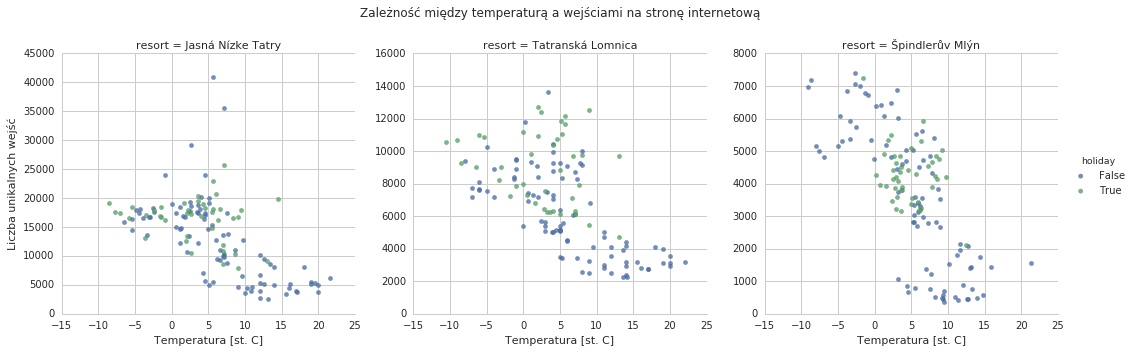

In [29]:
kws = dict(s=20, linewidth=.1, edgecolor="black", alpha=0.8)

g = sns.FacetGrid(df, col='resort', hue='holiday', size=5, sharey=False)
g = (g.map(plt.scatter, "temperature_max", "unique_users_all", **kws)).add_legend()

plt.subplots_adjust(top=0.85)
g.fig.suptitle('Zależność między temperaturą a wejściami na stronę internetową')
g.set_axis_labels(x_var='Temperatura [st. C]', y_var='Liczba unikalnych wejść')
plt.show()

W każdym przypadku można zaobserwować negatywną korelację - **wzrost temperatury oznacza spadek zainteresowania witryną.** Występuje duża wariancja.

**Spostrzeżenia**:
- w prawym dolnym rogu (mało wejść, duża temperatura) wyraźnie widać pomiary z dni pracujących (`holiday=False`),
- najwięcej wejść generowanych jest w przypadku < 10 st. C

### 10. Im więcej wejść na stronę ośrodka, tym więcej wzmianek (Brand24) i wyższa sprzedaż. 

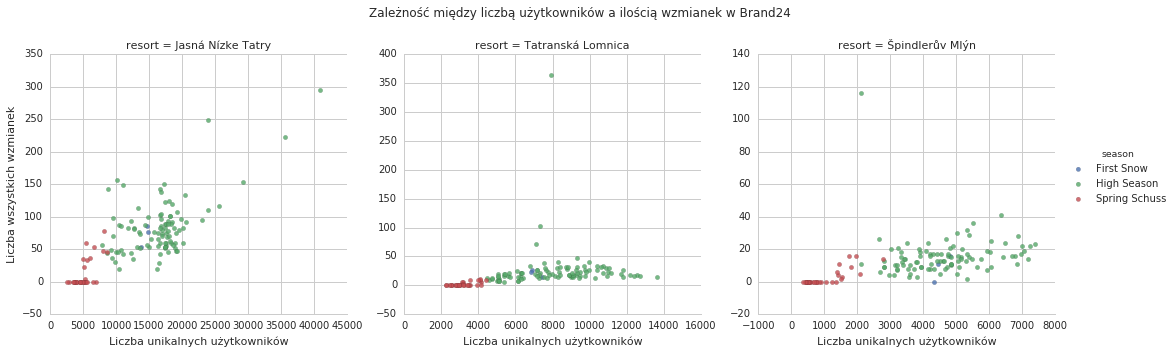

In [30]:
kws = dict(s=20, linewidth=.1, edgecolor="black", alpha=0.8)

g = sns.FacetGrid(df, col='resort', hue='season', size=5, sharey=False, sharex=False)
g = (g.map(plt.scatter, "unique_users_all", "brand24_all_mentions", **kws)).add_legend()

plt.subplots_adjust(top=0.85)
g.fig.suptitle('Zależność między liczbą użytkowników a ilością wzmianek w Brand24')
g.set_axis_labels(x_var='Liczba unikalnych użytkowników', y_var='Liczba wszystkich wzmianek')
plt.show()

We wszystkich przypadkach widać dodatnią korelację - **wzrost liczby wejść na stronę przekłada się na ilość wszystkich wzmianek**.

**Spostrzeżenia**:
- korelacja jest bardzo pozytywna dla ośrodka Jasná Nízke Tatry,
- Tatrzanska Lomnica odnotowała jeden dzien w ktorym otrzymala duzo wzmianek, oprocz tego ich liczba jest raczej stała
- wyraźnie widać podział na sezon główny i wiosenny

### 11. Wyższa sprzedaż następuje w dni pogodne (słaby wiatr, mniejsze zachmurzenie) niż w dni pochmurne i wietrzne. 
W jaki sposób opisać "dni pogodne"?

In [31]:
df['overall_conditions'].value_counts()

Clouds     246
Clear       55
Rain        48
Fog         22
Snow        19
Mist         4
Drizzle      2
Name: overall_conditions, dtype: int64

In [32]:
df['good_weather'].value_counts()

False    322
True      74
Name: good_weather, dtype: int64

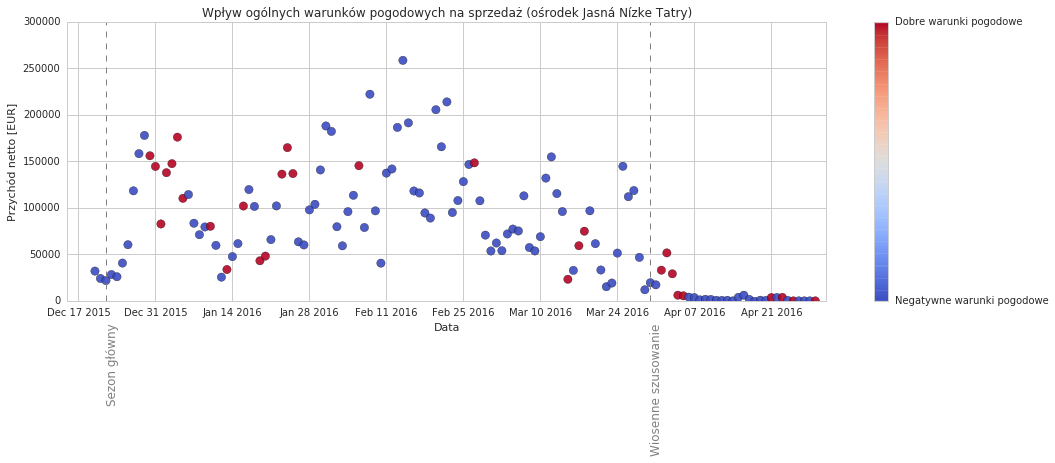

In [33]:
fig, ax = plt.subplots(figsize=(17, 5))

bs = jasna.groupby('day')['net_income_all', 'good_weather'].mean()
cm = plt.cm.get_cmap('coolwarm')

sc = plt.scatter(
    bs.index,
    bs['net_income_all'],
    c = bs['good_weather'],
    cmap = cm,
    s = 70,
    alpha=.9
)

ax.set_xlim(datetime.date(2015, 12, 15), datetime.date(2016, 5, 1))
ax.set_ylim([0, 300000])

ax.axvline(datetime.date(2015, 12, 22), color='grey', linestyle='--', lw=1)
ax.text(datetime.date(2015, 12, 22) , -35000 , 'Sezon główny', color='grey', rotation=90)

ax.axvline(datetime.date(2016, 3, 30), color='grey', linestyle='--', lw=1)
ax.text(datetime.date(2016, 3, 30) , -35000, 'Wiosenne szusowanie', color='grey', rotation=90)

ax.set_xlabel("Data")
ax.set_ylabel("Przychód netto [EUR]")
ax.set_title("Wpływ ogólnych warunków pogodowych na sprzedaż (ośrodek Jasná Nízke Tatry)")

cbar = plt.colorbar(sc, ticks=[0,1])
cbar.ax.set_yticklabels(['Negatywne warunki pogodowe', 'Dobre warunki pogodowe'])

plt.show()

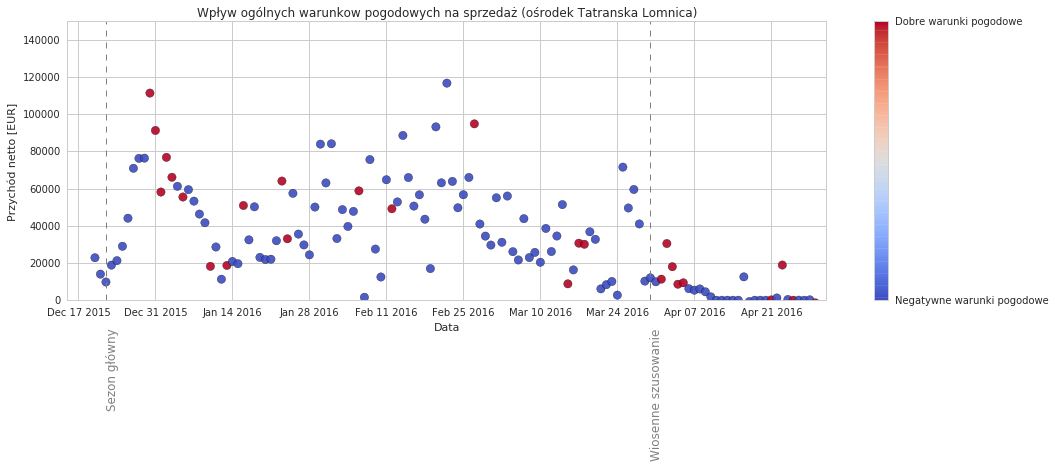

In [34]:
fig, ax = plt.subplots(figsize=(17, 5))

bs = tatranska.groupby('day')['net_income_all', 'good_weather'].mean()
cm = plt.cm.get_cmap('coolwarm')

sc = plt.scatter(
    bs.index,
    bs['net_income_all'],
    c = bs['good_weather'],
    cmap = cm,
    s = 70,
    alpha=.9
)

ax.set_xlim(datetime.date(2015, 12, 15), datetime.date(2016, 5, 1))
ax.set_ylim([0, 150000])

ax.axvline(datetime.date(2015, 12, 22), color='grey', linestyle='--', lw=1)
ax.text(datetime.date(2015, 12, 22) , -20000 , 'Sezon główny', color='grey', rotation=90)

ax.axvline(datetime.date(2016, 3, 30), color='grey', linestyle='--', lw=1)
ax.text(datetime.date(2016, 3, 30) , -20000, 'Wiosenne szusowanie', color='grey', rotation=90)

ax.set_xlabel("Data")
ax.set_ylabel("Przychód netto [EUR]")
ax.set_title("Wpływ ogólnych warunkow pogodowych na sprzedaż (ośrodek Tatranska Lomnica)")

cbar = plt.colorbar(sc, ticks=[0,1])
cbar.ax.set_yticklabels(['Negatywne warunki pogodowe', 'Dobre warunki pogodowe'])

plt.show()

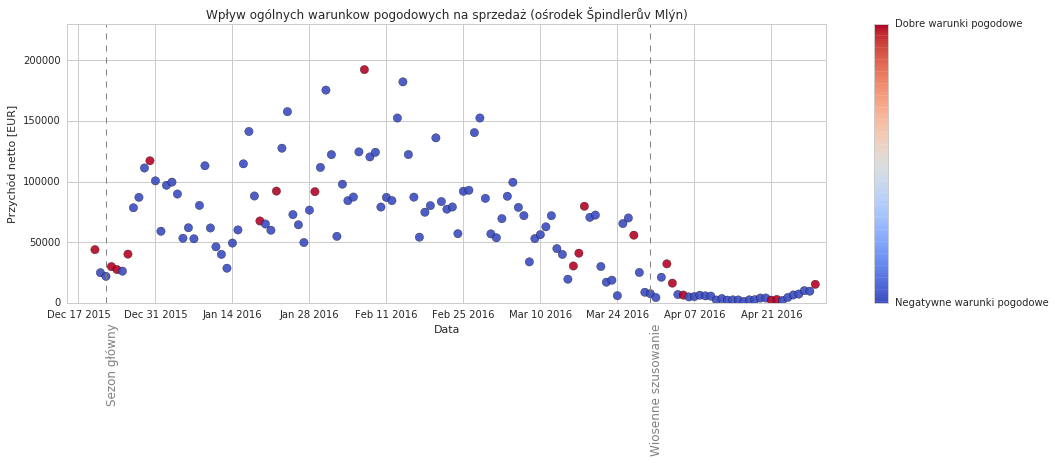

In [35]:
fig, ax = plt.subplots(figsize=(17, 5))

bs = spindleruv.groupby('day')['net_income_all', 'good_weather'].mean()
cm = plt.cm.get_cmap('coolwarm')

sc = plt.scatter(
    bs.index,
    bs['net_income_all'],
    c = bs['good_weather'],
    cmap = cm,
    s = 70,
    alpha=.9
)

ax.set_xlim(datetime.date(2015, 12, 15), datetime.date(2016, 5, 1))
ax.set_ylim([0, 230000])

ax.axvline(datetime.date(2015, 12, 22), color='grey', linestyle='--', lw=1)
ax.text(datetime.date(2015, 12, 22) , -25000 , 'Sezon główny', color='grey', rotation=90)

ax.axvline(datetime.date(2016, 3, 30), color='grey', linestyle='--', lw=1)
ax.text(datetime.date(2016, 3, 30) , -25000, 'Wiosenne szusowanie', color='grey', rotation=90)

ax.set_xlabel("Data")
ax.set_ylabel("Przychód netto [EUR]")
ax.set_title("Wpływ ogólnych warunkow pogodowych na sprzedaż (ośrodek Špindlerův Mlýn)")

cbar = plt.colorbar(sc, ticks=[0,1])
cbar.ax.set_yticklabels(['Negatywne warunki pogodowe', 'Dobre warunki pogodowe'])

plt.show()

Zbyt mało "sprzyjających dni", aby określić czy istnieją powiązania.

### 12. Niższa cena skipassa wpływa na wzrost sprzedaży.
W zgromadzonych danych ceny skipassów mają bardzo małą dynamikę. Nie mniej jednak możemy porównać jaką część sprzedaży zajmują karnety o niższej i wyższej cenie.

Przyjmując ustalenia jaka jest *"niższa cena karnetu"* dla każdego ośrodka na podstawie danych:

- dla Jasná Nízke Tatry niższa cena karnetu jest przyjmowana dla kwoty <= 18.5 EUR,
- dla Tatranská Lomnica <= 16.5 EUR,
- dla Špindlerův Mlýn <= 29 EUR

In [36]:
df.loc[df['resort'] == 'Jasná Nízke Tatry', 'skipass_lower_price'] = (jasna['skipass_price_avg'] <= 18.5)
df.loc[df['resort'] == 'Tatranská Lomnica', 'skipass_lower_price'] = (tatranska['skipass_price_avg'] <= 16.5)
df.loc[df['resort'] == 'Špindlerův Mlýn', 'skipass_lower_price'] = (spindleruv['skipass_price_avg'] <= 29)

Ciężko jest to porównać ponieważ:
- niższa cena skipassa była jedynie przez kilka dni na początku, gdzie nie było jeszcze takiego ruchu,
- nie mamy odpowiednio dużo danych z niższymi i normalymi cenami aby je porównywać

In [37]:
df['skipass_price_avg'].value_counts()

37.0    108
33.0    108
31.0    106
0.0      54
29.0     16
30.0      1
18.5      1
16.5      1
5.8       1
Name: skipass_price_avg, dtype: int64

In [38]:
df['skipass_lower_price'].value_counts()

False    323
True      73
Name: skipass_lower_price, dtype: int64

### 13. Niższa cena skipassa wpływa na wzrost sprzedaży, kiedy jest również więcej wzmianek (brand24).
W hipotezie 8 przedstawiono wpływ analizy wszystkich wzmianek dla ośrodka Jasna. Poniższe wykresy rozszerzają tamtą hipotezę od dodanie pozostałych dwóch ośrodków.

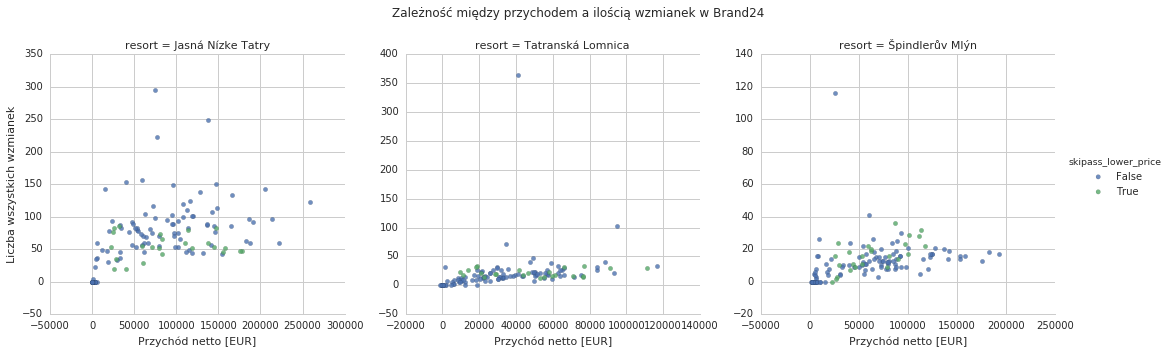

In [39]:
kws = dict(s=20, linewidth=.1, edgecolor="black", alpha=0.8)

g = sns.FacetGrid(df, col='resort', hue='skipass_lower_price', size=5, sharey=False, sharex=False)
g = (g.map(plt.scatter, "net_income_all", "brand24_all_mentions", **kws)).add_legend()

plt.subplots_adjust(top=0.85)
g.fig.suptitle('Zależność między przychodem a ilością wzmianek w Brand24')
g.set_axis_labels(x_var='Przychód netto [EUR]', y_var='Liczba wszystkich wzmianek')
plt.show()

Nie widać wyraźnej zależności pomiędzy badanymi zmiennymi. Jedynie w przypadku Jasnej więcej niż >100 wzmianek generowanych było jedynie w momencie regularnej ceny karnetu - to może obalić tezę o wpływie ceny na wzrost sprzedaży i wzmianek.

### 14. Zależność pomiędzy unikalnymi użytkownikami a przychodem netto
W zależności od sezonu

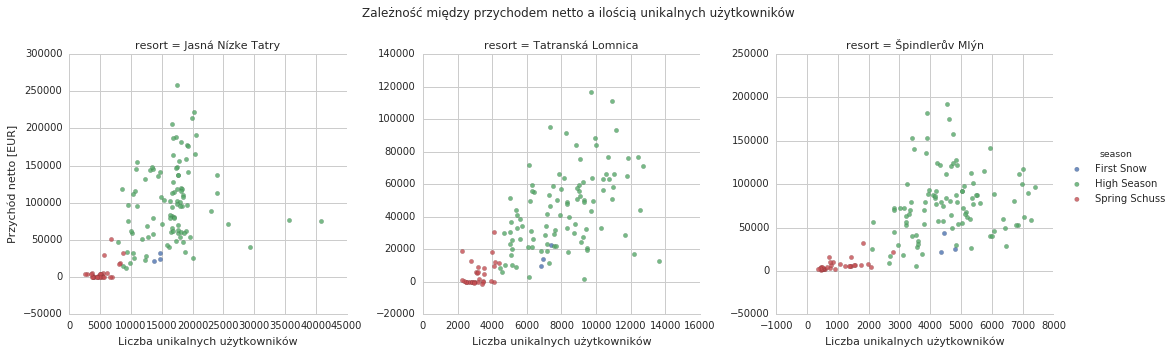

In [40]:
kws = dict(s=20, linewidth=.1, edgecolor="black", alpha=0.8)

g = sns.FacetGrid(df, col='resort', hue='season', size=5, sharey=False, sharex=False)
g = (g.map(plt.scatter, "unique_users_all", "net_income_all", **kws)).add_legend()

plt.subplots_adjust(top=0.85)
g.fig.suptitle('Zależność między przychodem netto a ilością unikalnych użytkowników')
g.set_axis_labels(x_var='Liczba unikalnych użytkowników', y_var='Przychód netto [EUR]')
plt.show()

Kształtuje się dodania korelacja pomiędzy liczbą unikalnych uzytkowników odwiedzającymi stronę, a osiągniętym przychodem.

### 15. Zależność pomiędzy ilością unikanych użytkowników pochodzących z Polski a przychodem netto
W zależności od tego jaka była pogoda

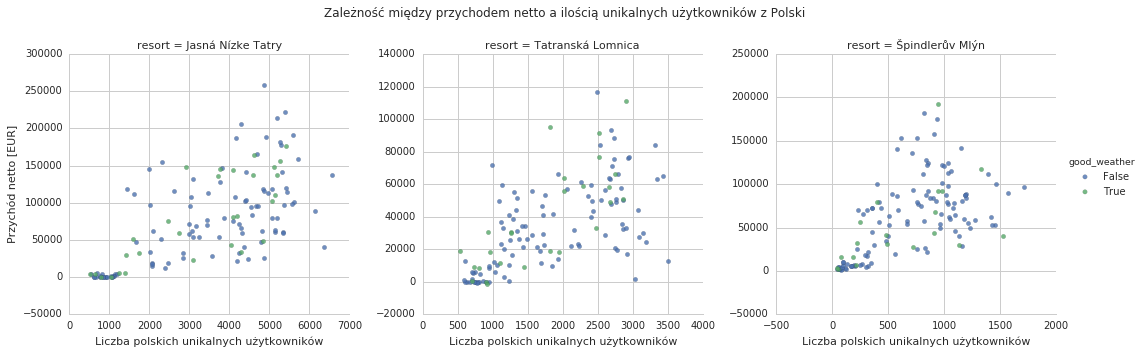

In [41]:
kws = dict(s=20, linewidth=.1, edgecolor="black", alpha=0.8)

g = sns.FacetGrid(df, col='resort', hue='good_weather', size=5, sharey=False, sharex=False)
g = (g.map(plt.scatter, "unique_users_poland", "net_income_all", **kws)).add_legend()

plt.subplots_adjust(top=0.85)
g.fig.suptitle('Zależność między przychodem netto a ilością unikalnych użytkowników z Polski')
g.set_axis_labels(x_var='Liczba polskich unikalnych użytkowników', y_var='Przychód netto [EUR]')
plt.show()

Podobnie jak w hipotezie 15 - istnieje dodatnia korelacja, która zdaje się nie zależeć od ogólnych warunków pogodowych.

### 16. Czy pogoda wpływa na ruch w sieci?
Przedstawiono zależność pomidzy unikalnymi użytkownikami a pogodą w horyzoncie czasowym dla 3 stoków

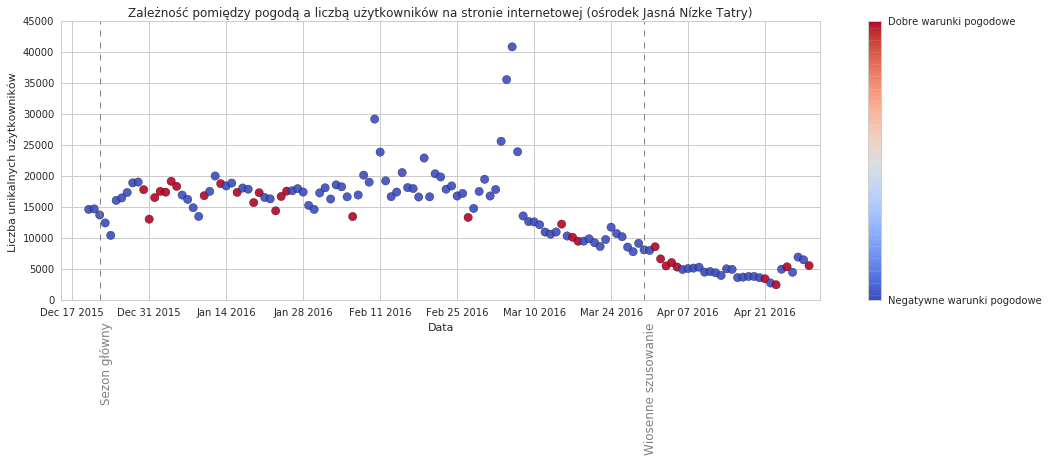

In [42]:
fig, ax = plt.subplots(figsize=(17, 5))

bs = jasna.groupby('day')['unique_users_all', 'good_weather'].mean()
cm = plt.cm.get_cmap('coolwarm')

sc = plt.scatter(
    bs.index,
    bs['unique_users_all'],
    c = bs['good_weather'],
    cmap = cm,
    s = 70,
    alpha=.9
)

ax.set_xlim(datetime.date(2015, 12, 15), datetime.date(2016, 5, 1))
ax.set_ylim([0, 45000])

ax.axvline(datetime.date(2015, 12, 22), color='grey', linestyle='--', lw=1)
ax.text(datetime.date(2015, 12, 22) , -5000 , 'Sezon główny', color='grey', rotation=90)

ax.axvline(datetime.date(2016, 3, 30), color='grey', linestyle='--', lw=1)
ax.text(datetime.date(2016, 3, 30) , -5000, 'Wiosenne szusowanie', color='grey', rotation=90)

ax.set_xlabel("Data")
ax.set_ylabel("Liczba unikalnych użytkowników")
ax.set_title("Zależność pomiędzy pogodą a liczbą użytkowników na stronie internetowej (ośrodek Jasná Nízke Tatry)")

cbar = plt.colorbar(sc, ticks=[0,1])
cbar.ax.set_yticklabels(['Negatywne warunki pogodowe', 'Dobre warunki pogodowe'])

plt.show()

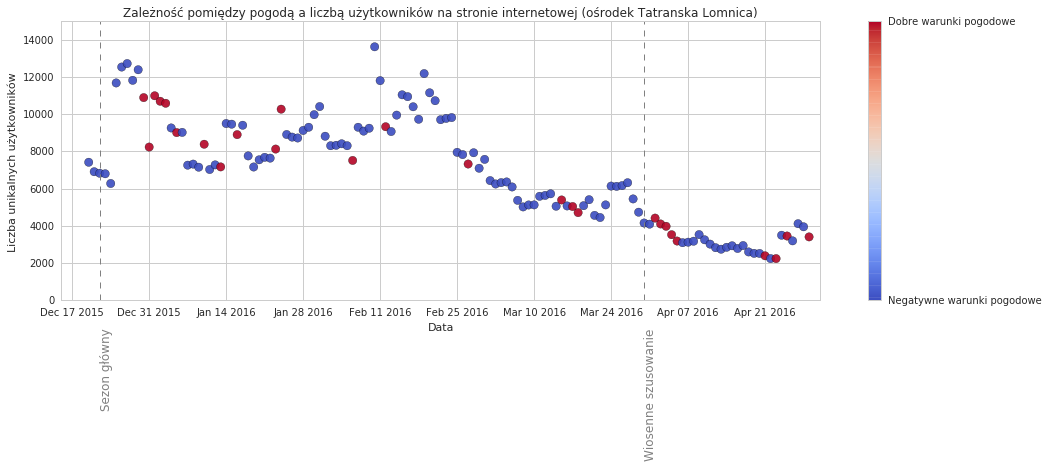

In [43]:
fig, ax = plt.subplots(figsize=(17, 5))

bs = tatranska.groupby('day')['unique_users_all', 'good_weather'].mean()
cm = plt.cm.get_cmap('coolwarm')

sc = plt.scatter(
    bs.index,
    bs['unique_users_all'],
    c = bs['good_weather'],
    cmap = cm,
    s = 70,
    alpha=.9
)

ax.set_xlim(datetime.date(2015, 12, 15), datetime.date(2016, 5, 1))
ax.set_ylim([0, 15000])

ax.axvline(datetime.date(2015, 12, 22), color='grey', linestyle='--', lw=1)
ax.text(datetime.date(2015, 12, 22) , -2000 , 'Sezon główny', color='grey', rotation=90)

ax.axvline(datetime.date(2016, 3, 30), color='grey', linestyle='--', lw=1)
ax.text(datetime.date(2016, 3, 30) , -2000, 'Wiosenne szusowanie', color='grey', rotation=90)

ax.set_xlabel("Data")
ax.set_ylabel("Liczba unikalnych użytkowników")
ax.set_title("Zależność pomiędzy pogodą a liczbą użytkowników na stronie internetowej (ośrodek Tatranska Lomnica)")

cbar = plt.colorbar(sc, ticks=[0,1])
cbar.ax.set_yticklabels(['Negatywne warunki pogodowe', 'Dobre warunki pogodowe'])

plt.show()

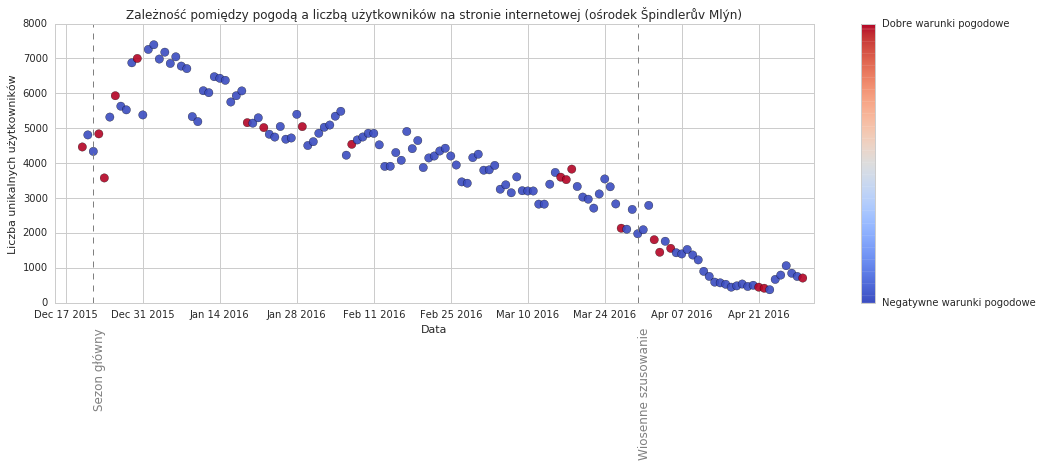

In [44]:
fig, ax = plt.subplots(figsize=(17, 5))

bs = spindleruv.groupby('day')['unique_users_all', 'good_weather'].mean()
cm = plt.cm.get_cmap('coolwarm')

sc = plt.scatter(
    bs.index,
    bs['unique_users_all'],
    c = bs['good_weather'],
    cmap = cm,
    s = 70,
    alpha=.9
)

ax.set_xlim(datetime.date(2015, 12, 15), datetime.date(2016, 5, 1))
ax.set_ylim([0, 8000])

ax.axvline(datetime.date(2015, 12, 22), color='grey', linestyle='--', lw=1)
ax.text(datetime.date(2015, 12, 22) , -1000 , 'Sezon główny', color='grey', rotation=90)

ax.axvline(datetime.date(2016, 3, 30), color='grey', linestyle='--', lw=1)
ax.text(datetime.date(2016, 3, 30) , -1000, 'Wiosenne szusowanie', color='grey', rotation=90)

ax.set_xlabel("Data")
ax.set_ylabel("Liczba unikalnych użytkowników")
ax.set_title("Zależność pomiędzy pogodą a liczbą użytkowników na stronie internetowej (ośrodek Špindlerův Mlýn)")

cbar = plt.colorbar(sc, ticks=[0,1])
cbar.ax.set_yticklabels(['Negatywne warunki pogodowe', 'Dobre warunki pogodowe'])

plt.show()

Brak powiązania między ogólnymi warunkami pogodowymi a wzrostem ruchu na stronie internetowej.

**Spostrzeżenia**:
- widoczna tendencja spadkowa wizyt na witrynach w ujęciu czasowym dla wszsytkich ośrodków

### 17. Zależność kuru EUR/PLN na sprzedaż w ujęciu dziennym

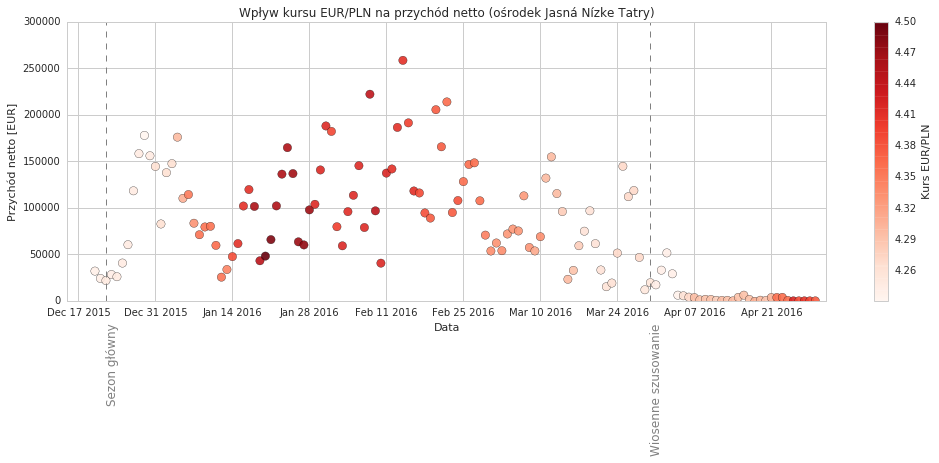

In [45]:
fig, ax = plt.subplots(figsize=(17, 5))

bs = jasna.groupby('day')['net_income_all', 'EURPLN'].mean()
cm = plt.cm.get_cmap('Reds')

sc = plt.scatter(
    bs.index,
    bs['net_income_all'],
    c = bs['EURPLN'],
    cmap = cm,
    s = 70,
    alpha=.9
)

ax.set_xlim(datetime.date(2015, 12, 15), datetime.date(2016, 5, 1))
ax.set_ylim([0, 300000])

ax.axvline(datetime.date(2015, 12, 22), color='grey', linestyle='--', lw=1)
ax.text(datetime.date(2015, 12, 22) , -35000 , 'Sezon główny', color='grey', rotation=90)

ax.axvline(datetime.date(2016, 3, 30), color='grey', linestyle='--', lw=1)
ax.text(datetime.date(2016, 3, 30) , -35000, 'Wiosenne szusowanie', color='grey', rotation=90)

ax.set_xlabel("Data")
ax.set_ylabel("Przychód netto [EUR]")
ax.set_title("Wpływ kursu EUR/PLN na przychód netto (ośrodek Jasná Nízke Tatry)")

cbar = plt.colorbar(sc)
cbar.set_label('Kurs EUR/PLN')

plt.show()

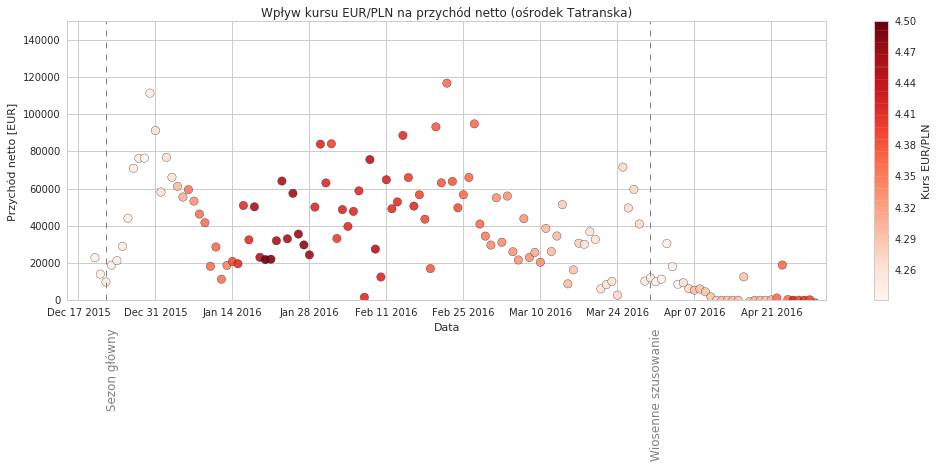

In [46]:
fig, ax = plt.subplots(figsize=(17, 5))

bs = tatranska.groupby('day')['net_income_all', 'EURPLN'].mean()
cm = plt.cm.get_cmap('Reds')

sc = plt.scatter(
    bs.index,
    bs['net_income_all'],
    c = bs['EURPLN'],
    cmap = cm,
    s = 70,
    alpha=.9
)

ax.set_xlim(datetime.date(2015, 12, 15), datetime.date(2016, 5, 1))
ax.set_ylim([0, 150000])

ax.axvline(datetime.date(2015, 12, 22), color='grey', linestyle='--', lw=1)
ax.text(datetime.date(2015, 12, 22) , -20000 , 'Sezon główny', color='grey', rotation=90)

ax.axvline(datetime.date(2016, 3, 30), color='grey', linestyle='--', lw=1)
ax.text(datetime.date(2016, 3, 30) , -20000, 'Wiosenne szusowanie', color='grey', rotation=90)

ax.set_xlabel("Data")
ax.set_ylabel("Przychód netto [EUR]")
ax.set_title("Wpływ kursu EUR/PLN na przychód netto (ośrodek Tatranska)")

cbar = plt.colorbar(sc)
cbar.set_label('Kurs EUR/PLN')

plt.show()

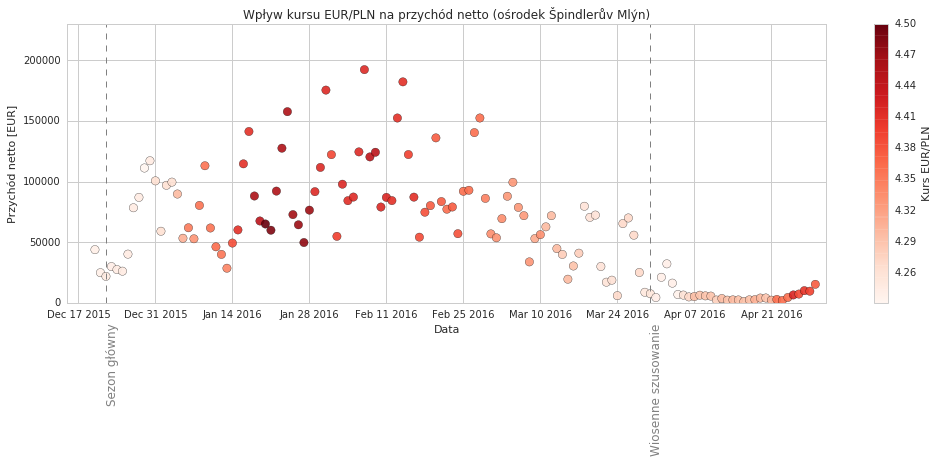

In [47]:
fig, ax = plt.subplots(figsize=(17, 5))

bs = spindleruv.groupby('day')['net_income_all', 'EURPLN'].mean()
cm = plt.cm.get_cmap('Reds')

sc = plt.scatter(
    bs.index,
    bs['net_income_all'],
    c = bs['EURPLN'],
    cmap = cm,
    s = 70,
    alpha=.9
)

ax.set_xlim(datetime.date(2015, 12, 15), datetime.date(2016, 5, 1))
ax.set_ylim([0, 230000])

ax.axvline(datetime.date(2015, 12, 22), color='grey', linestyle='--', lw=1)
ax.text(datetime.date(2015, 12, 22) , -25000 , 'Sezon główny', color='grey', rotation=90)

ax.axvline(datetime.date(2016, 3, 30), color='grey', linestyle='--', lw=1)
ax.text(datetime.date(2016, 3, 30) , -25000, 'Wiosenne szusowanie', color='grey', rotation=90)

ax.set_xlabel("Data")
ax.set_ylabel("Przychód netto [EUR]")
ax.set_title("Wpływ kursu EUR/PLN na przychód netto (ośrodek Špindlerův Mlýn)")

cbar = plt.colorbar(sc)
cbar.set_label('Kurs EUR/PLN')

plt.show()

Największy kurs EUR/PLN przypada na sezon główny. W tym czasie przychody rosną więc teza -> niższy kurs EUR/PLN wyższa sprzedaż nie ma miejsca.

### 18. Jak wygląda sprzedaż z kanałów organic/eshop dla każdego ośrodka
W horyzoncie czasowym

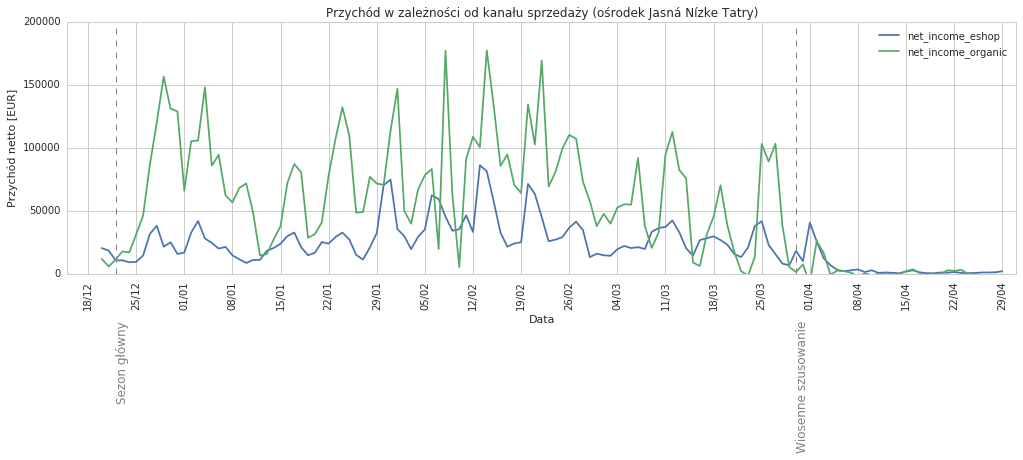

In [48]:
fig, ax = plt.subplots(figsize=(17, 5))

plt.plot(jasna['day'], jasna['net_income_eshop'])
plt.plot(jasna['day'], jasna['net_income_organic'])

ax.set_xlim(datetime.date(2015, 12, 15), datetime.date(2016, 5, 1))
ax.set_ylim([-2, 200000])

ax.axvline(datetime.date(2015, 12, 22), color='grey', linestyle='--', lw=1)
ax.text(datetime.date(2015, 12, 22) , -45000 , 'Sezon główny', color='grey', rotation=90)

ax.axvline(datetime.date(2016, 3, 30), color='grey', linestyle='--', lw=1)
ax.text(datetime.date(2016, 3, 30) , -45000, 'Wiosenne szusowanie', color='grey', rotation=90)

ax.set_xlabel("Data")
ax.set_ylabel("Przychód netto [EUR]")
ax.set_title("Przychód w zależności od kanału sprzedaży (ośrodek Jasná Nízke Tatry)")

ax.xaxis.set_major_locator(WeekdayLocator(byweekday=4))
ax.xaxis.set_major_formatter(DateFormatter('%d/%m'))

fig.autofmt_xdate(rotation=90, ha='center')

plt.legend(loc='best')

plt.show()

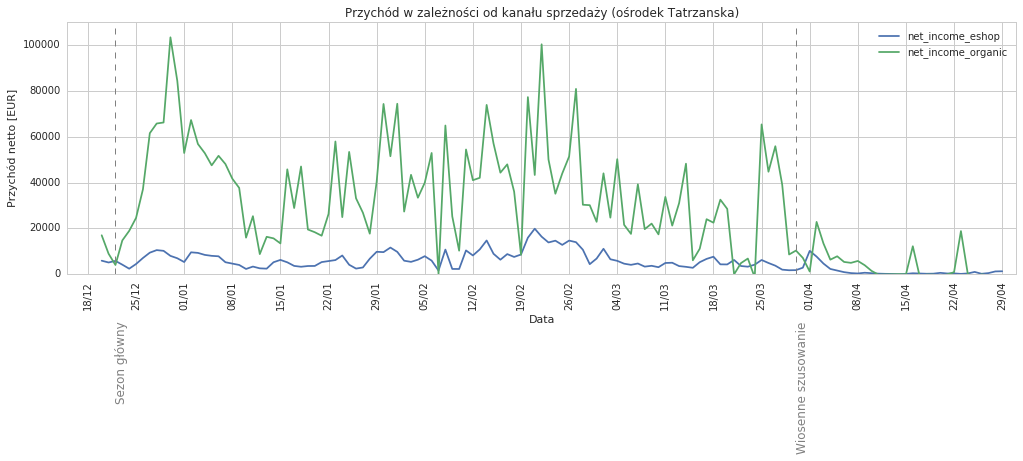

In [49]:
fig, ax = plt.subplots(figsize=(17, 5))

plt.plot(tatranska['day'], tatranska['net_income_eshop'])
plt.plot(tatranska['day'], tatranska['net_income_organic'])

ax.set_xlim(datetime.date(2015, 12, 15), datetime.date(2016, 5, 1))
ax.set_ylim([-2, 110000])

ax.axvline(datetime.date(2015, 12, 22), color='grey', linestyle='--', lw=1)
ax.text(datetime.date(2015, 12, 22) , -25000 , 'Sezon główny', color='grey', rotation=90)

ax.axvline(datetime.date(2016, 3, 30), color='grey', linestyle='--', lw=1)
ax.text(datetime.date(2016, 3, 30) , -25000, 'Wiosenne szusowanie', color='grey', rotation=90)

ax.set_xlabel("Data")
ax.set_ylabel("Przychód netto [EUR]")
ax.set_title("Przychód w zależności od kanału sprzedaży (ośrodek Tatrzanska)")

ax.xaxis.set_major_locator(WeekdayLocator(byweekday=4))
ax.xaxis.set_major_formatter(DateFormatter('%d/%m'))

fig.autofmt_xdate(rotation=90, ha='center')

plt.legend(loc='best')

plt.show()

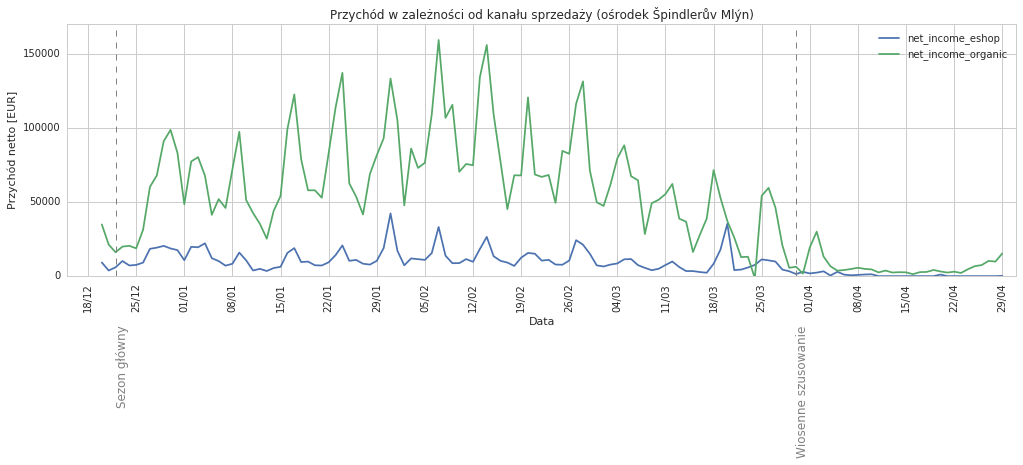

In [50]:
fig, ax = plt.subplots(figsize=(17, 5))

plt.plot(spindleruv['day'], spindleruv['net_income_eshop'])
plt.plot(spindleruv['day'], spindleruv['net_income_organic'])

ax.set_xlim(datetime.date(2015, 12, 15), datetime.date(2016, 5, 1))
ax.set_ylim([-2, 170000])

ax.axvline(datetime.date(2015, 12, 22), color='grey', linestyle='--', lw=1)
ax.text(datetime.date(2015, 12, 22) , -40000 , 'Sezon główny', color='grey', rotation=90)

ax.axvline(datetime.date(2016, 3, 30), color='grey', linestyle='--', lw=1)
ax.text(datetime.date(2016, 3, 30) , -40000, 'Wiosenne szusowanie', color='grey', rotation=90)

ax.set_xlabel("Data")
ax.set_ylabel("Przychód netto [EUR]")
ax.set_title("Przychód w zależności od kanału sprzedaży (ośrodek Špindlerův Mlýn)")

ax.xaxis.set_major_locator(WeekdayLocator(byweekday=4))
ax.xaxis.set_major_formatter(DateFormatter('%d/%m'))

fig.autofmt_xdate(rotation=90, ha='center')

plt.legend(loc='best')

plt.show()

### 19. Wpływ deszczu na sprzedaż

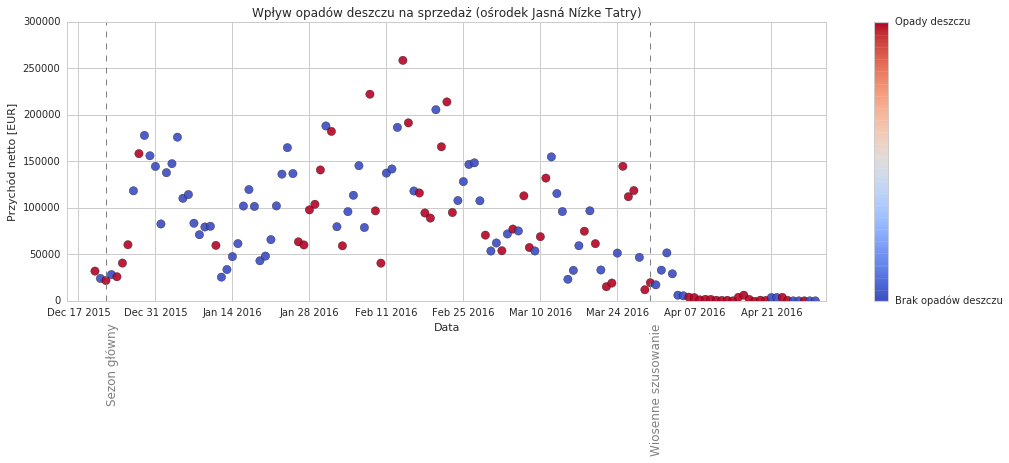

In [51]:
fig, ax = plt.subplots(figsize=(17, 5))

bs = jasna.groupby('day')['net_income_all', 'was_raining'].mean()
cm = plt.cm.get_cmap('coolwarm')

sc = plt.scatter(
    bs.index,
    bs['net_income_all'],
    c = bs['was_raining'],
    cmap = cm,
    s = 70,
    alpha=.9
)

ax.set_xlim(datetime.date(2015, 12, 15), datetime.date(2016, 5, 1))
ax.set_ylim([0, 300000])

ax.axvline(datetime.date(2015, 12, 22), color='grey', linestyle='--', lw=1)
ax.text(datetime.date(2015, 12, 22) , -35000 , 'Sezon główny', color='grey', rotation=90)

ax.axvline(datetime.date(2016, 3, 30), color='grey', linestyle='--', lw=1)
ax.text(datetime.date(2016, 3, 30) , -35000, 'Wiosenne szusowanie', color='grey', rotation=90)

ax.set_xlabel("Data")
ax.set_ylabel("Przychód netto [EUR]")
ax.set_title("Wpływ opadów deszczu na sprzedaż (ośrodek Jasná Nízke Tatry)")

cbar = plt.colorbar(sc, ticks=[0,1])
cbar.ax.set_yticklabels(['Brak opadów deszczu', 'Opady deszczu'])

plt.show()

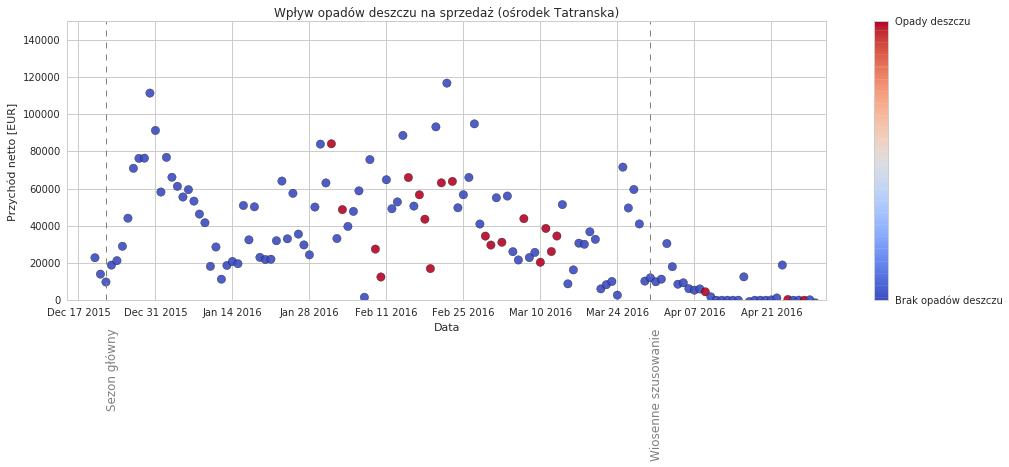

In [52]:
fig, ax = plt.subplots(figsize=(17, 5))

bs = tatranska.groupby('day')['net_income_all', 'was_raining'].mean()
cm = plt.cm.get_cmap('coolwarm')

sc = plt.scatter(
    bs.index,
    bs['net_income_all'],
    c = bs['was_raining'],
    cmap = cm,
    s = 70,
    alpha=.9
)

ax.set_xlim(datetime.date(2015, 12, 15), datetime.date(2016, 5, 1))
ax.set_ylim([0, 150000])

ax.axvline(datetime.date(2015, 12, 22), color='grey', linestyle='--', lw=1)
ax.text(datetime.date(2015, 12, 22) , -20000 , 'Sezon główny', color='grey', rotation=90)

ax.axvline(datetime.date(2016, 3, 30), color='grey', linestyle='--', lw=1)
ax.text(datetime.date(2016, 3, 30) , -20000, 'Wiosenne szusowanie', color='grey', rotation=90)

ax.set_xlabel("Data")
ax.set_ylabel("Przychód netto [EUR]")
ax.set_title("Wpływ opadów deszczu na sprzedaż (ośrodek Tatranska)")

cbar = plt.colorbar(sc, ticks=[0,1])
cbar.ax.set_yticklabels(['Brak opadów deszczu', 'Opady deszczu'])

plt.show()

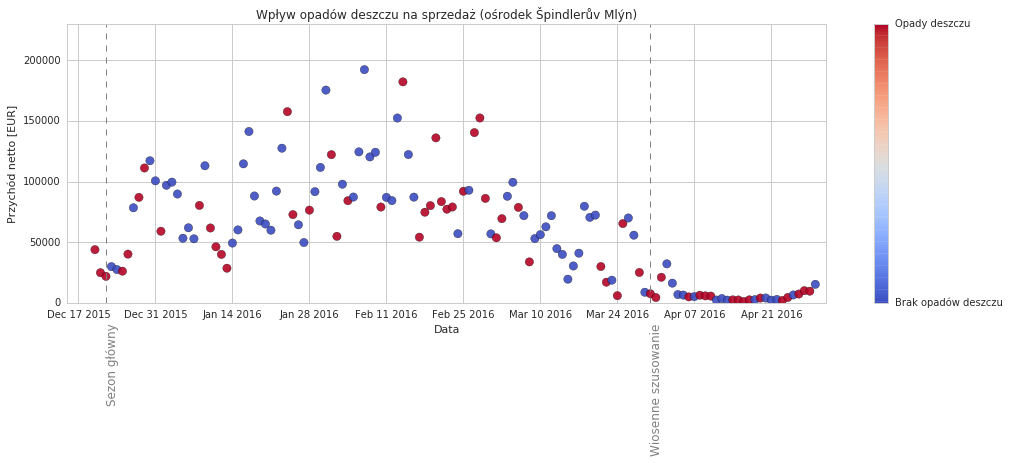

In [53]:
fig, ax = plt.subplots(figsize=(17, 5))

bs = spindleruv.groupby('day')['net_income_all', 'was_raining'].mean()
cm = plt.cm.get_cmap('coolwarm')

sc = plt.scatter(
    bs.index,
    bs['net_income_all'],
    c = bs['was_raining'],
    cmap = cm,
    s = 70,
    alpha=.9
)

ax.set_xlim(datetime.date(2015, 12, 15), datetime.date(2016, 5, 1))
ax.set_ylim([0, 230000])

ax.axvline(datetime.date(2015, 12, 22), color='grey', linestyle='--', lw=1)
ax.text(datetime.date(2015, 12, 22) , -25000 , 'Sezon główny', color='grey', rotation=90)

ax.axvline(datetime.date(2016, 3, 30), color='grey', linestyle='--', lw=1)
ax.text(datetime.date(2016, 3, 30) , -25000, 'Wiosenne szusowanie', color='grey', rotation=90)

ax.set_xlabel("Data")
ax.set_ylabel("Przychód netto [EUR]")
ax.set_title("Wpływ opadów deszczu na sprzedaż (ośrodek Špindlerův Mlýn)")

cbar = plt.colorbar(sc, ticks=[0,1])
cbar.ax.set_yticklabels(['Brak opadów deszczu', 'Opady deszczu'])

plt.show()

Brak wyraźnej zależności. W Jasná Nízke Tatry występuje ciąg deszczowych dni powiązany ze wzrostem sprzedaży.